<a href="https://colab.research.google.com/github/chrfranco/06_MAIR_Aprendizaje_No_Supervisado/blob/master/Actividad%205%20Final%20Grupo%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo final aprendizaje no supervisado
## Aprendizaje no supervisado
## Grupo 1
### Integrantes:
* Andrea María Álvarez Rodríguez 
* Christian Francisco Franco Sánchez 
* Oscar Enrique Ureña Márquez 


# Descripción  y mejoras en algoritmo K-Means.
En esta sección se presenta una implementación del algoritmo de K-means  considerando como versión vainilla aquella donde los centroides se inicializan aleatoriamente y  se compara  contra  variaciones de inicialización y asignación de  centroides. 

## Convergencia
En esta implementación del K means la convergencia esta limitada principalmente al número de iteraciones o al score de la silueta del siguiente modo: <br>.
Si el número de iteraciones supera el  max_iter permitido  o sí el score de siluta  de la iteración actual  NO es mayor que el promedio de las ultimas 5 iteraciones detiene el proceso iterativo.

## Mejoras en algoritmo de K-means.
Para el algoritmo de K-Meas se trabajó principalmente  en la implementación de diferentes algoritmos de inicialización vs el performance del algoritmo de inicialización aleatoria. <br>
El algoritmo de inicialización aleatoria se vuelve poco confiable  cuando la dimensionalidad incrementa mucho  principalmente respecto al número de muestras pero tambien afectado por el número de centros y por el número de atributos.
## Algoritmo particion percentil.
Este algoritmo es una modificación del algoritmo propuesto Al-Daoud’s [2005] en  el cual primeramente se busca la columna con mayor varianza y en base a ella se hacen y en base a dicha columna se hacen  submuestras sub-sets en base a los rangos de percentiles. Posteriormente para cada rango de percentil se toma la mediana (percentil 50) del rango de datos y ese se considera el  centroide inicial. Dado que se  generantan K particiones, la mediana de cada rango de percentil es un cluster inicial. Este algoritmo se debilita cuando la varianza se mueve en más de un sentido (atributo) de manera significativa.

## Algoritmo multi arranque (Multi Start).
El algoritmo multiarranque (desarrollo propio)  se basa en lo en una búsqueda aleatoria del juego de K clusters iniciales que maximizen  el valor de la matriz de distancias. En otras palabras  iterativamente  muestrea aleatoriamente sin reemplazo K instancias  10*n veces (siendo n el número de instancias) y mantiene aquel alla combinación de instancias que generen la matriz de distancias máxima con el objetivo de  obtener los clusters más separados posibles. Este algoritmo es computacionalmente  pesado respecto a los tradicionales pero es funcional cuando los centroides estan distribuídos a lo lardo de un rango bastante grande y es afectado principalmente cuando los los centroides estan conjuntos en pocos cuadrantes del plano.

## Algoritmo de refinamiento de clusters:
Este algoritmo (desarrollo propio) no se basa en el método de incialización  de los centroides iniciales, si no que por el contrario interviene en el proceso de recalculo de centroides por medio del siguiente proceso: 
* 1) Para cada cluster calcula la fracción f de instancias más alejadas al centroide
* 2) Para cada cluster calcula su  cluster más cercano $(C2)$ diferente al cluster $(C1)$ siendo evaluado.
* 3) Para cada cluster  mide el coeficiente de la silueta $(S1)$ posteriormente asigna la instancia  al cluster $C2$ y calcula el coeficiente de silueta $S2$. <br> Si $S2>S1$ mantiene el intercambio de la asignación al cluster vecino, de otro modo la deja como estaba en el cluster inicial. <br>
La principal  desventaja de este algoritmo es que añadeuna fuerte carga computacional segun el numero de instancias a procesar ya que la fracción $f$ es funcion de las $n$ instancias. Por otro lado ayuda  pretende lidiar con clusters que se encuentran  uno muy  cerca del otro. <br>
Principalmente añade 2 hiperparametros que son : <br>
* 1) Refine_interval: Especifica cada cuantas iteraciones el algoritmo buscara evalual la fracción f de instancias mas alejadas a los centroídes.
* 2) f: Especifica la fracción de instancias por cluster que seran evaluadas  cada vez que sera  hecho el proceso de refinamiento. <br>
El algoritmo hace un print  de !!!!!!!!!Switched between clusters !!!!!!!!!! cuando el intercambio de la etiqueta de la instancia a su cluster vecino resultó en una incremento en el score de la silueta. <br>


## K-means usando PCA
PCA, al ser un algoritmo utilizado para la reducción de dimensionalidad lineal, puede ayudar a visualizar de los datos y explicar la varianza de los nuevos componentes obtenidos tras su aplicación. Posteriormente, al encontrar una base de coordenadas significativas para expresar los datos, podemos utilizar esta información para seleccionar clusters con mucha mayor precisión.
Según varias propuestas estudiadas (ver referencias) aplicaremos PCA al conjunto de algoritmos optimizados comparando silueta y precisión.

# Definición de la función

In [0]:
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs


In [0]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score

In [0]:
class KMeans_VIU():

  '''
    Arguments: \n
    K: Number of clusters \n
    init_type: Centroids initialization type that might be: \n
      random: Takes randomly from a set of point from datasets as initial clusters \n
      pp: Kmeans++ method 

  '''
  def distancia_euclidiana(self,x, y):   
    return np.sqrt(np.sum((x-y)**2))

  def distancia_euclidiana_grupo(self,x, C):   
    return np.sqrt(np.sum(np.power(C-x,2),axis=1))

  def matriz_distancias(self,X, distancia):
    mD = np.zeros((X.shape[0],X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0],:],X[pair[1],:])
    return mD

  def __init__(self,K,init_type='random'):
    import numpy as np
    import pandas as pd

    self.K=K #Store the desired number of clusters
    self.init_type=init_type

  def Closest_Centroid(self,x, C,p=2):
    '''
    Arguments:\n
    x: Single instance of sample
    C: Group of centroids to calculate distance
    p: expent p of Minkowsky distance (integer). Default=2 : Euclidean

    returns:
    Index of the closest centroid

    '''   
    #Calculate distance from the instance i to the all centroids
    d_centroid= np.sqrt(np.sum(np.power(C-x,p),axis=1))
    #Calculate the index of the minimun distance to centroids
    return (np.unravel_index(np.argmin(d_centroid, axis=None), d_centroid.shape))[0]


  #Fit procedure--------------------------------
  def fit(self,X,iter_max=200,p=2,
          plot=False,Refine=False,Refine_interval=2,verbose=False,y=None):

    from sklearn.metrics import silhouette_score
    from sklearn.metrics import accuracy_score
    from copy import deepcopy
    import matplotlib.pyplot as plt
    from tqdm import tqdm
    from scipy.stats import mode
    '''
    X: Numpy array data  for train data \n
    p: p factor on Minkowsky distance equation \n
    iter_max: Max number of iterations \n
    '''
    self.X=X #Store initial data
    self.Score=[]# To  store instrinsecal score
    if y.all()!=None:
      self.Acc=[]
      self.y=y

    #Call for initialization function
    if self.init_type=='random':
      #Call function to assign inital clusters
      Init_Clust_Index=self.Clusters_Init()  ##Bring indexes of init centroids
      Initial_Centroids= self.X[Init_Clust_Index,:]  ## Assign to centroids
    elif self.init_type=='Perc_partition':
      Init_Clust_Index=None
      Initial_Centroids=self.Clusters_Init()
      print(Initial_Centroids)
    elif self.init_type=='MultiStart':
      Init_Clust_Index=None
      Initial_Centroids=self.Clusters_Init()
      print(Initial_Centroids)

    #Attach to atribute initialized centroids
    self.Centroids=deepcopy(Initial_Centroids) #Attach to object Centroid attribute
    self.Centroids_index=deepcopy(Init_Clust_Index)#Attach to object index centroid attr

    #Preparation for iterative process
    iter_=0 #Set initial parameter for iterations
    Idx_arr=np.ones((self.X).shape[0])*-1 #Initialize an empty array  with -1 to store centroid idx for each instance
    #Iterative process to determine closest centroids


    #Iterative  process over all instances:
    for it in tqdm(range(iter_max),mininterval=5):
      for i in range((self.X).shape[0]): #Iterate over all instances of X
        #Calculate the closest centroid for each instance of X
        Idx_arr[i]=self.Closest_Centroid(self.X[i,:],self.Centroids)

      #Set the clusters on an array  attribute to preserve output
      self.Cluster_Id=Idx_arr 

      #Recalculate centroids
      Range_centroids= list(range(self.K))
      for K_i in Range_centroids:
        #For each centroid K_i find the corresponding instances on Idx_arr
        Index_K_i=np.argwhere(Idx_arr==K_i)
        #Slice X to get instances based on indexes
        Temp_arr=(self.X)[Index_K_i,:]
        #Reassign centroid K_i
        self.Centroids[K_i,:]=Temp_arr.mean(axis=0)

      #print(it+1,":::",str((it+1)%Refine_interval))
      if Refine and (it+1)%Refine_interval==0:
        #Call refine procedure
        print("Called refine function")
        self.Centroids,self.Cluster_Id= self.Refine_Centroids(self.X,self.Centroids,self.Cluster_Id)

      self.Score.append(silhouette_score(self.X,labels= self.Cluster_Id))
      if y.all()!=None: #Evaluatue acc

        lbls = np.zeros_like(self.Cluster_Id)
        for i in range(self.K):
          mask = (self.Cluster_Id == i)
          lbls[mask] = mode(y[mask])[0]
        
        self.Acc.append(accuracy_score(self.y,lbls))


      if it >10 and np.mean(self.Score[-6:-2])>= self.Score[-1]:
        print("Stopped iterations at ", it , " iterations")
        break
        

      if verbose:
        print("Centroids:",self.Centroids)




    # Only for plotting purposes        
    if plot:
      #Validation of dimensions
      if self.X.shape[1]==2:
        plt.scatter(self.X[:,0],self.X[:,1],marker='o',c=self.Cluster_Id)
        plt.scatter(self.Centroids[:,0],self.Centroids[:,1],
                    marker='*',c=self.Centroids_index)
        plt.grid(True)
        plt.title("K means with "+ str(self.K)+ " clusters. \n Init type:"+ self.init_type)
        plt.show()
      else:
        print("Cannot plot something diferent to 2D")




    self.silhouette=silhouette_score(self.X,labels= self.Cluster_Id)
    print(" Silhouette score:",self.silhouette)
    if y.all()!= None:
      print("Accuracy:",self.Acc[-1])



  def Refine_Centroids(self,X,Centroids,Clust_ID,f=0.05):
    '''
    This function is used iteratively to refine centroids.
    Every n iteratations this functions is called by .fit procedure
    Function exchange some samples (1 by 1) with their closest centroid
    diffent to is own centroid and evaluates instrinsecal function-
    If the result of the intrinsecal function is better  exhange remains permanent.

    f : fraction of instances of each cluster to be test  for exchange
    '''
    #
    from sklearn.metrics import silhouette_score
    # 1) Iterate over each centroid
    #print("Unique CLust ID:",np.unique(Clust_ID),"X shape:",X.shape)
    for C in range(len(Centroids)):
      #For centroid C find it´s closest centroid different to him
      Current_Cent=Centroids[C,:]

      Compare_centroids= Centroids.copy()

      #Change the value of current centroid on array compare_centroid
      #to avoid self match
      Compare_centroids[C,:]=Compare_centroids[C,:]*1e6

      #Remove the current centroid for comparison
      #Compare_centroids= np.delete(Compare_centroids,C,axis=0)

      #Find the closest centroid to Current_Cent that lives on Compare_centroids array
      Closest_Cent= self.Closest_Centroid(Current_Cent, Compare_centroids,p=2)
      
      #Create match list
      Match_ID=np.arange(0,len(Clust_ID))
      Match_ID= np.argwhere(Clust_ID==C)
      Match_ID=Match_ID.flatten()
      #print("MAtch ID;;;;;;;;;;;;;;;;;;;;;;;;;;;;",Match_ID.shape,"\n",Match_ID)

      #Now for Centroid C bring all their assignations.
      
      Assigned=X[Match_ID]
      #print("Assigned X",Assigned)

      ## Calculate least close instances  from centroid
      Distances=self.distancia_euclidiana_grupo(Assigned, Current_Cent)
      Distances=Distances.reshape(-1,1)
      #print("X shape",Assigned.shape, "Dist shape",Distances.shape)
      idx_col=(np.arange(len(Distances))).reshape(-1,1)
      #Attach and index column
      Distances=np.hstack((idx_col,Distances))
      #print("Distancess:::\n",Distances)
      #Now order the distances by column 1 as decreasing order
      Dist_sort = Distances[Distances[:,1].argsort()[::-1]]
      #print("DIst sort \n",Dist_sort)
      #And select  the fraction of least close instances
      n_instances=int((Dist_sort.shape)[0]*f)
      # Get the far indexes
      Far_index=Dist_sort[0:n_instances,0]
      Far_index=[int(i) for i in Far_index]
      #print("Far indx",Far_index)
      Far_instances=X[Far_index,:]
      #print("Far instances",Far_instances)

      for F_idx in Far_index:
        #print("Far index:",F_idx)
        #Try to exchange each instance with the closest cluster
        # C is the index of the current centroid bein evaluated
        # Closest_Cent is the index of the centroid closest to C
        # Clust_ID is the array of  labels for centroids
        #print("Clust ID",Clust_ID)
        Original_ID=Clust_ID[F_idx]
        #print("Original ID",Original_ID)

        #Calculate Current Silohute score
        S1=silhouette_score(X,labels=Clust_ID)
        #Make the exchange
        Clust_ID[F_idx]= Closest_Cent
        S2=silhouette_score(X,labels=Clust_ID)
        #print("\n S1:",S1," S2:",S2,"\n")

        if S2 > S1:
          pass
          #Do nothing, keep change done
          print("!!!!!!!!!Switched between clusters !!!!!!!!!!")
        else:
          #GO Back to previous state
          #print("No change")
          Clust_ID[F_idx]=Original_ID

    return Centroids,Clust_ID









  #Clusters initialization  procedures--------------------------------------
  def Clusters_Init(self):
    
    from tqdm import tqdm
    #Create an index range for all the instances
    Index=np.arange( ((self.X).shape)[0] )

    if self.init_type=='random':
      Initial_indexes=np.random.choice(Index,self.K,replace=False)
      print("\n \n Finished centroids initialization \n\n")
      return Initial_indexes # Selected  list of indexes

    elif self.init_type=='Perc_partition':
      # Determine the attribute with highest variance
      # 1st scale al attribute from 0-1
     
      MIN=self.X.min(axis=0)
      MAX=self.X.max(axis=0)
      X_=(self.X-MIN)/(MAX-MIN)
      
      #Calulate variance
      variance=X_.var(axis=0)
      #Determine which attribute has the highest variance
      col=(np.unravel_index(np.argmax(variance, axis=None),variance.shape))[0]
      #Calculate percentiles to work with
      Bounds=np.percentile(X_[:,col],q=np.linspace(0,100,1+self.K))
      #Declare a -1´s array to store initial centroids
      Centroids=np.ones((self.K,X_.shape[1]))*-1
      
      #Isolate groups and calculate mean
      for i in range(len(Bounds)-1):
        #Slice data according to percentile bounds
        Low_perc=Bounds[i]
        High_perc=Bounds[i+1]
        Slice_Data=X_[(X_[:,col]>=Low_perc) & (X_[:,0]<High_perc)]
        #Take mean of data
        #Mean_Scaled_centroid=Slice_Data.mean(axis=0)
        Mean_Scaled_centroid=np.percentile(Slice_Data,50)
        #Bring centroid to original scale
        Mean_Centroid= Mean_Scaled_centroid*(MAX-MIN)+MIN
        #Store the centroid
        Centroids[i,:]=Mean_Centroid
      print("\n \n Finished centroids initialization \n\n")
      return Centroids #Return K rows of centroids array
      pass

    elif self.init_type=='MultiStart':
      
      D_max=0
      #Make multiple samplings and get the one with the biggest distance sum
      iterations=self.X.shape[0]*50
      for i in tqdm(range(iterations),mininterval=2):
        
        #Select randomly sample index
        Initial_indexes=np.random.choice(Index,self.K,replace=False)
        #Determine centroids
        Initial_Centroids= self.X[Initial_indexes,:]
        # Calculate their distance matrix
        D=self.matriz_distancias(Initial_Centroids,self.distancia_euclidiana)
        
        if D.sum()> D_max:
          D_max=D.sum()
          print("D max:",D_max)
          Scattered_Centroids=Initial_Centroids
          print("\n Finished centroids initialization ")
      return Scattered_Centroids

    



np.random.seed(17)


# Dataset 1

El dataset cargado tiene 1999 instancias.


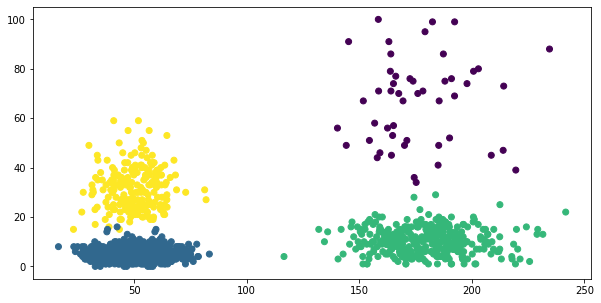

In [0]:
np.random.seed(17) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

data_file_url = 'https://raw.githubusercontent.com/flifuehu/viu-unsupervised-learning/master/datasets/sinteticos/dataset_cuatro_diferente_densidad.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]
print('El dataset cargado tiene',Dy.size,'instancias.')

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

  0%|          | 0/200 [00:00<?, ?it/s]

Dx shape;::: (1999, 2)

 
 Method: Random

 
 Finished centroids initialization 


Stopped iterations at  11  iterations


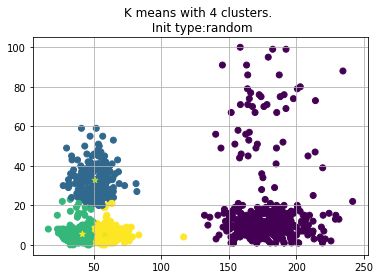

  0%|          | 0/200 [00:00<?, ?it/s]

 Silhouette score: 0.5427285943977928
Accuracy: 0.966983491745873

 
 Method: Random + Refine

 
 Finished centroids initialization 


Called refine function


  2%|▏         | 3/200 [00:15<16:51,  5.13s/it]

Called refine function


  3%|▎         | 6/200 [00:31<16:47,  5.20s/it]

Called refine function


  4%|▍         | 9/200 [00:47<16:39,  5.23s/it]

Called refine function
Stopped iterations at  11  iterations


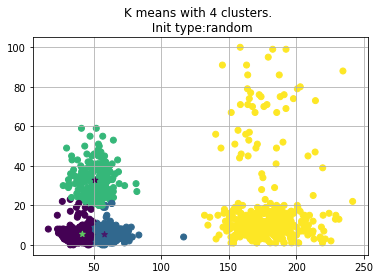


  0%|          | 0/99950 [00:00<?, ?it/s]

 Silhouette score: 0.5427285943977928
Accuracy: 0.966983491745873

 
 Method: MultiStart
D max: 198.57295999345723

 Finished centroids initialization 
D max: 1241.2868249791386

 Finished centroids initialization 
D max: 1271.4474532016902

 Finished centroids initialization 
D max: 1310.521589580408

 Finished centroids initialization 
D max: 1437.3415512694257

 Finished centroids initialization 
D max: 1636.028303512236

 Finished centroids initialization 
D max: 1651.0334920346081

 Finished centroids initialization 
D max: 1668.7704245520774

 Finished centroids initialization 



 15%|█▍        | 14852/99950 [00:04<00:23, 3656.88it/s]

D max: 1671.056381186181

 Finished centroids initialization 



 22%|██▏       | 22317/99950 [00:06<00:21, 3679.16it/s]

D max: 1699.5455688948878

 Finished centroids initialization 



 30%|███       | 30077/99950 [00:08<00:18, 3737.08it/s]

D max: 1777.6464804801872

 Finished centroids initialization 



  0%|          | 0/200 [00:00<?, ?it/s]

[[225.68   2.  ]
 [ 34.11   1.  ]
 [234.52  88.  ]
 [ 58.82  30.  ]]


Stopped iterations at  11  iterations


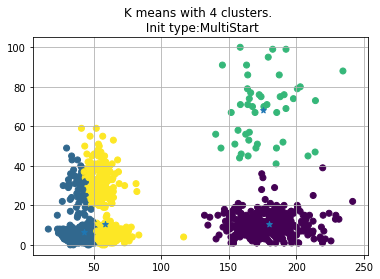


  0%|          | 0/99950 [00:00<?, ?it/s]

 Silhouette score: 0.42788323076590856
Accuracy: 0.8924462231115557

 
 Method: MultiStart + Refine
D max: 816.6424526328276

 Finished centroids initialization 
D max: 918.3427845515007

 Finished centroids initialization 
D max: 1001.2242946657985

 Finished centroids initialization 
D max: 1032.1014553908872

 Finished centroids initialization 
D max: 1081.7693667621008

 Finished centroids initialization 
D max: 1325.266391175619

 Finished centroids initialization 
D max: 1430.5670315041891

 Finished centroids initialization 
D max: 1522.46180678623

 Finished centroids initialization 
D max: 1568.6028448268512

 Finished centroids initialization 
D max: 1587.6111857892806

 Finished centroids initialization 
D max: 1588.2872712583176

 Finished centroids initialization 



  7%|▋         | 7436/99950 [00:02<00:24, 3717.63it/s]

D max: 1651.0506059699228

 Finished centroids initialization 
D max: 1669.0569390900846

 Finished centroids initialization 



 29%|██▊       | 28503/99950 [00:08<00:19, 3578.36it/s]

D max: 1692.743817896991

 Finished centroids initialization 



  0%|          | 0/200 [00:00<?, ?it/s]

[[190.85   9.  ]
 [ 40.46   7.  ]
 [234.52  88.  ]
 [ 35.13  38.  ]]
Called refine function
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!



  2%|▏         | 3/200 [00:17<18:52,  5.75s/it]

Called refine function
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!



  3%|▎         | 6/200 [00:34<18:27,  5.71s/it]

Called refine function
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!



  4%|▍         | 9/200 [00:51<18:06,  5.69s/it]

Called refine function
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!



  6%|▌         | 12/200 [01:07<17:47,  5.68s/it]

Stopped iterations at  12  iterations


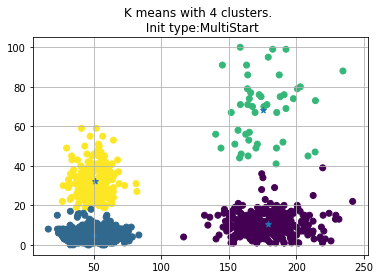



  0%|          | 0/200 [00:00<?, ?it/s]

 Silhouette score: 0.5900131037332426
Accuracy: 0.9959979989994997

 
 Method: Percentile partition

 
 Finished centroids initialization 


[[34.4156      8.        ]
 [46.69       13.44754127]
 [54.99       17.13119119]
 [69.54       23.58867389]]
Stopped iterations at  13  iterations


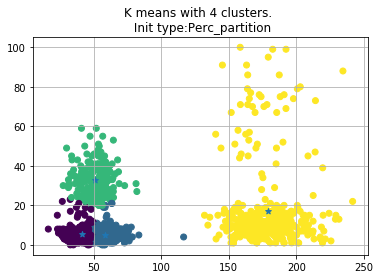




  0%|          | 0/200 [00:00<?, ?it/s]

 Silhouette score: 0.5428115639036457
Accuracy: 0.966983491745873

 
 Method: Percentile partition + Refine

 
 Finished centroids initialization 


[[34.4156      8.        ]
 [46.69       13.44754127]
 [54.99       17.13119119]
 [69.54       23.58867389]]
Called refine function
!!!!!!!!!Switched between clusters !!!!!!!!!!





  2%|▏         | 3/200 [00:16<17:46,  5.41s/it]

Called refine function





  3%|▎         | 6/200 [00:32<17:29,  5.41s/it]

Called refine function





  4%|▍         | 9/200 [00:48<17:10,  5.40s/it]

Called refine function





  6%|▌         | 12/200 [01:04<16:48,  5.36s/it]

Stopped iterations at  13  iterations


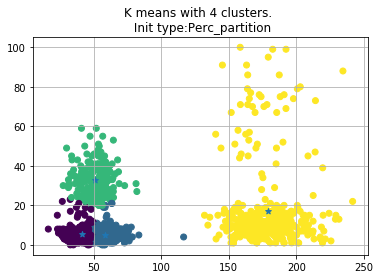

 Silhouette score: 0.5428115639036457
Accuracy: 0.966983491745873


In [0]:


print("Dx shape;:::",Dx.shape)
np.random.seed(5)
R=3
Clust=4

Method_Name='Random'
print("\n \n Method:", Method_Name)
C1=KMeans_VIU(K=Clust,init_type='random')
C1.fit(Dx, plot=True, Refine=False, y=Dy)

Method_Name='Random + Refine'
print("\n \n Method:", Method_Name)
C2=KMeans_VIU(K=Clust,init_type='random')
C2.fit(Dx, plot=True, Refine=True, y=Dy,Refine_interval=R)

Method_Name='MultiStart'
print("\n \n Method:", Method_Name)
C3=KMeans_VIU(K=Clust,init_type='MultiStart')
C3.fit(Dx, plot=True, Refine=False, y=Dy)

Method_Name='MultiStart + Refine'
print("\n \n Method:", Method_Name)
C4=KMeans_VIU(K=Clust,init_type='MultiStart')
C4.fit(Dx, plot=True, Refine=True, y=Dy,Refine_interval=R)

Method_Name='Percentile partition'
print("\n \n Method:", Method_Name)
C5=KMeans_VIU(K=Clust,init_type='Perc_partition')
C5.fit(Dx, plot=True, Refine=False, y=Dy)

Method_Name='Percentile partition + Refine'
print("\n \n Method:", Method_Name)
C6=KMeans_VIU(K=Clust,init_type='Perc_partition')
C6.fit(Dx, plot=True, Refine=True, y=Dy,Refine_interval=R)
       


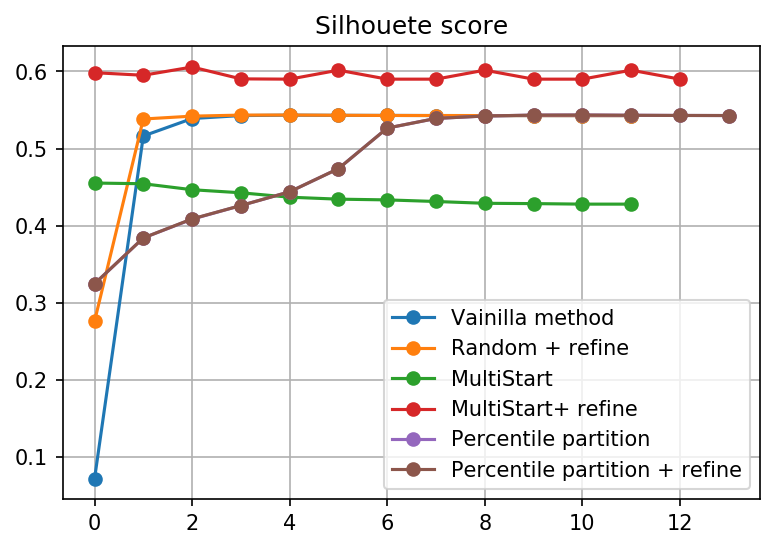

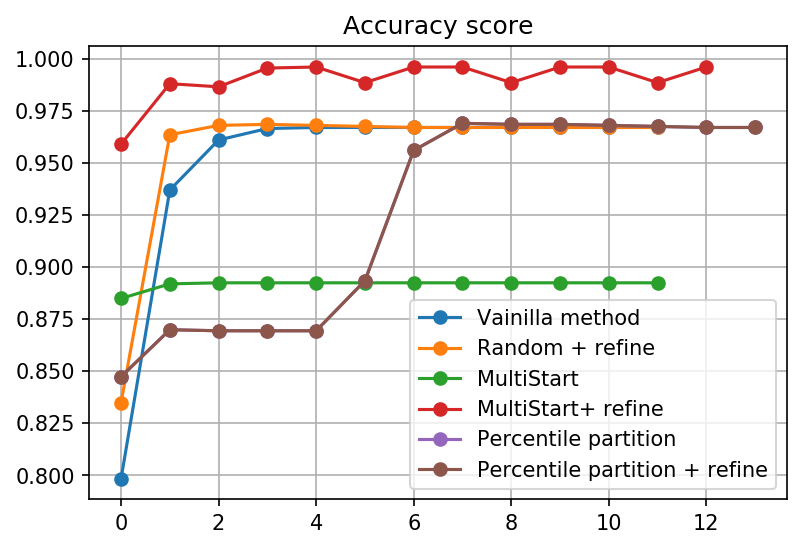

In [0]:

plt.rcParams['figure.dpi']=150

plt.plot(C1.Score, marker='o', label='Vainilla method')
plt.plot(C2.Score,marker='o', label='Random + refine')
plt.plot(C3.Score,marker='o', label='MultiStart')
plt.plot(C4.Score,marker='o', label='MultiStart+ refine')
plt.plot(C5.Score,marker='o', label='Percentile partition')
plt.plot(C6.Score,marker='o', label='Percentile partition + refine')
plt.grid(True)
plt.title("Silhouete score")
plt.legend(loc='best')


plt.show()


plt.plot(C1.Acc, marker='o', label='Vainilla method')
plt.plot(C2.Acc,marker='o', label='Random + refine')
plt.plot(C3.Acc,marker='o', label='MultiStart')
plt.plot(C4.Acc,marker='o', label='MultiStart+ refine')
plt.plot(C5.Acc,marker='o', label='Percentile partition')
plt.plot(C6.Acc,marker='o', label='Percentile partition + refine')
plt.grid(True)
plt.title("Accuracy score")
plt.legend(loc='best')


## **PCA**

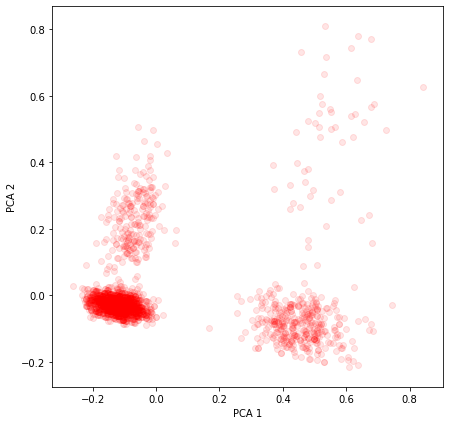

In [0]:
import sklearn.preprocessing
from sklearn.decomposition import PCA

scalerDx = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
Xp = scalerDx.fit_transform(Dx)
porcentajeVE = 0.95
sklearn_pca = PCA(porcentajeVE)

pComponents = sklearn_pca.fit_transform(Xp)

plt.figure(figsize = (7,7))
plt.scatter(pComponents[:,0], pComponents[:,1], c= 'r', alpha=.1) 
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

([<matplotlib.axis.XTick at 0x7fef31d819b0>,
 <a list of 2 Text xticklabel objects>)

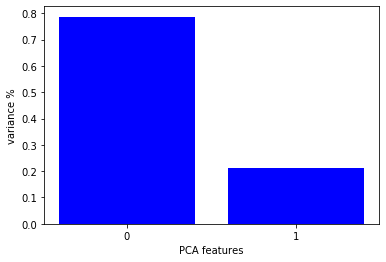

In [0]:
# Plot the explained variances
features = range(sklearn_pca.n_components_)
plt.bar(features, sklearn_pca.explained_variance_ratio_, color='b')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
#pca_comp = pd.DataFrame(pComponents)

  0%|          | 0/200 [00:00<?, ?it/s]

Dx shape;::: (1999, 2)

 
 Method: Random

 
 Finished centroids initialization 


Stopped iterations at  19  iterations


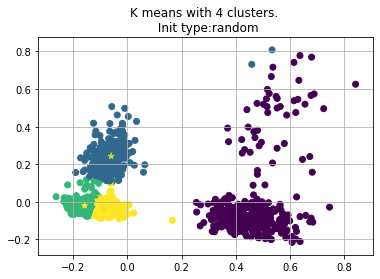

  0%|          | 0/200 [00:00<?, ?it/s]

 Silhouette score: 0.47531285606482476
Accuracy: 0.9699849924962481

 
 Method: Random + Refine

 
 Finished centroids initialization 


Called refine function
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!


  2%|▏         | 3/200 [00:16<18:14,  5.56s/it]

Called refine function
!!!!!!!!!Switched between clusters !!!!!!!!!!


  3%|▎         | 6/200 [00:33<17:57,  5.55s/it]

Called refine function


  4%|▍         | 9/200 [00:49<17:36,  5.53s/it]

Called refine function


  6%|▌         | 12/200 [01:06<17:23,  5.55s/it]

Called refine function


  8%|▊         | 15/200 [01:23<17:04,  5.54s/it]

Called refine function


  9%|▉         | 18/200 [01:39<16:46,  5.53s/it]

Stopped iterations at  19  iterations


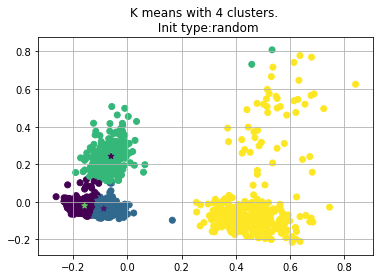


  0%|          | 0/99950 [00:00<?, ?it/s]

 Silhouette score: 0.47531285606482476
Accuracy: 0.9699849924962481

 
 Method: MultiStart
D max: 1.636912836709489

 Finished centroids initialization 
D max: 5.66702037742596

 Finished centroids initialization 
D max: 6.718221847314245

 Finished centroids initialization 
D max: 8.079397758188414

 Finished centroids initialization 
D max: 8.096495643397478

 Finished centroids initialization 
D max: 9.666608289337582

 Finished centroids initialization 



  9%|▉         | 8900/99950 [00:02<00:20, 4449.80it/s]

D max: 9.749587489176395

 Finished centroids initialization 



 27%|██▋       | 26980/99950 [00:06<00:16, 4485.14it/s]

D max: 9.99690793287431

 Finished centroids initialization 
D max: 10.057892426445687

 Finished centroids initialization 



  0%|          | 0/200 [00:00<?, ?it/s]

[[ 0.63685984 -0.21060941]
 [-0.19928679 -0.05626885]
 [ 0.84139675  0.6256345 ]
 [-0.03569304  0.20710118]]


Stopped iterations at  11  iterations


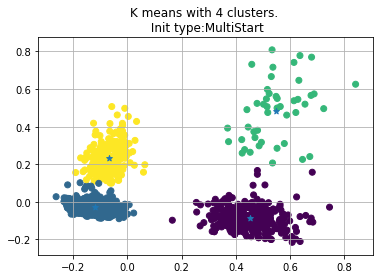


  0%|          | 0/99950 [00:00<?, ?it/s]

 Silhouette score: 0.7476508535654351
Accuracy: 0.9959979989994997

 
 Method: MultiStart + Refine
D max: 3.7399199482261007

 Finished centroids initialization 
D max: 4.088801514845804

 Finished centroids initialization 
D max: 4.447598415948264

 Finished centroids initialization 
D max: 4.564648009205979

 Finished centroids initialization 
D max: 6.231014624656314

 Finished centroids initialization 
D max: 6.704577265967615

 Finished centroids initialization 
D max: 7.85485763740756

 Finished centroids initialization 
D max: 8.322890837557509

 Finished centroids initialization 
D max: 8.979231301014803

 Finished centroids initialization 
D max: 9.252341264302961

 Finished centroids initialization 
D max: 9.737813546859446

 Finished centroids initialization 



  9%|▊         | 8624/99950 [00:02<00:21, 4311.57it/s]

D max: 9.79006075363313

 Finished centroids initialization 



 36%|███▌      | 35630/99950 [00:08<00:14, 4430.21it/s]

D max: 9.849775468255608

 Finished centroids initialization 



  0%|          | 0/200 [00:00<?, ?it/s]

[[-0.00979261  0.49756575]
 [ 0.48321391 -0.19056758]
 [-0.13340026 -0.00808306]
 [ 0.84139675  0.6256345 ]]
Called refine function
!!!!!!!!!Switched between clusters !!!!!!!!!!



  2%|▏         | 3/200 [00:17<19:19,  5.89s/it]

Called refine function



  3%|▎         | 6/200 [00:35<19:08,  5.92s/it]

Called refine function



  4%|▍         | 9/200 [00:53<18:52,  5.93s/it]

Called refine function
Stopped iterations at  11  iterations


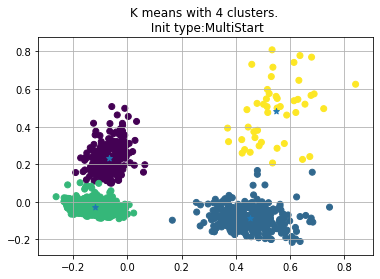



  0%|          | 0/200 [00:00<?, ?it/s]

 Silhouette score: 0.7476508535654351
Accuracy: 0.9959979989994997

 
 Method: Percentile partition

 
 Finished centroids initialization 


[[-0.12599507 -0.08810515]
 [-0.10156085 -0.06545778]
 [-0.0701946  -0.03638531]
 [ 0.11963525  0.13956249]]
Stopped iterations at  11  iterations


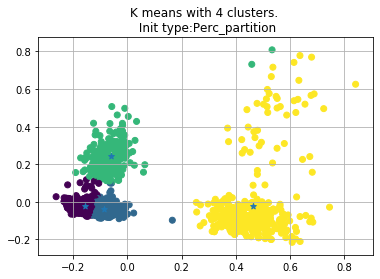




  0%|          | 0/200 [00:00<?, ?it/s]

 Silhouette score: 0.4754631443145782
Accuracy: 0.9699849924962481

 
 Method: Percentile partition + Refine

 
 Finished centroids initialization 


[[-0.12599507 -0.08810515]
 [-0.10156085 -0.06545778]
 [-0.0701946  -0.03638531]
 [ 0.11963525  0.13956249]]
Called refine function
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between cl




  2%|▏         | 3/200 [00:16<18:26,  5.62s/it]

Called refine function





  3%|▎         | 6/200 [00:33<18:05,  5.59s/it]

Called refine function





  4%|▍         | 9/200 [00:50<17:48,  5.59s/it]

Called refine function
Stopped iterations at  11  iterations


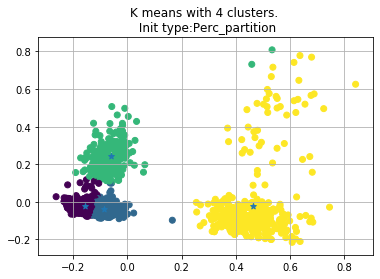

 Silhouette score: 0.4754631443145782
Accuracy: 0.9699849924962481


In [0]:


print("Dx shape;:::",Dx.shape)
np.random.seed(5)
R=3
Clust=4

Method_Name='Random'
print("\n \n Method:", Method_Name)
C1=KMeans_VIU(K=Clust,init_type='random')
C1.fit(pComponents, plot=True, Refine=False, y=Dy)

Method_Name='Random + Refine'
print("\n \n Method:", Method_Name)
C2=KMeans_VIU(K=Clust,init_type='random')
C2.fit(pComponents, plot=True, Refine=True, y=Dy,Refine_interval=R)

Method_Name='MultiStart'
print("\n \n Method:", Method_Name)
C3=KMeans_VIU(K=Clust,init_type='MultiStart')
C3.fit(pComponents, plot=True, Refine=False, y=Dy)

Method_Name='MultiStart + Refine'
print("\n \n Method:", Method_Name)
C4=KMeans_VIU(K=Clust,init_type='MultiStart')
C4.fit(pComponents, plot=True, Refine=True, y=Dy,Refine_interval=R)

Method_Name='Percentile partition'
print("\n \n Method:", Method_Name)
C5=KMeans_VIU(K=Clust,init_type='Perc_partition')
C5.fit(pComponents, plot=True, Refine=False, y=Dy)

Method_Name='Percentile partition + Refine'
print("\n \n Method:", Method_Name)
C6=KMeans_VIU(K=Clust,init_type='Perc_partition')
C6.fit(pComponents, plot=True, Refine=True, y=Dy,Refine_interval=R)
       


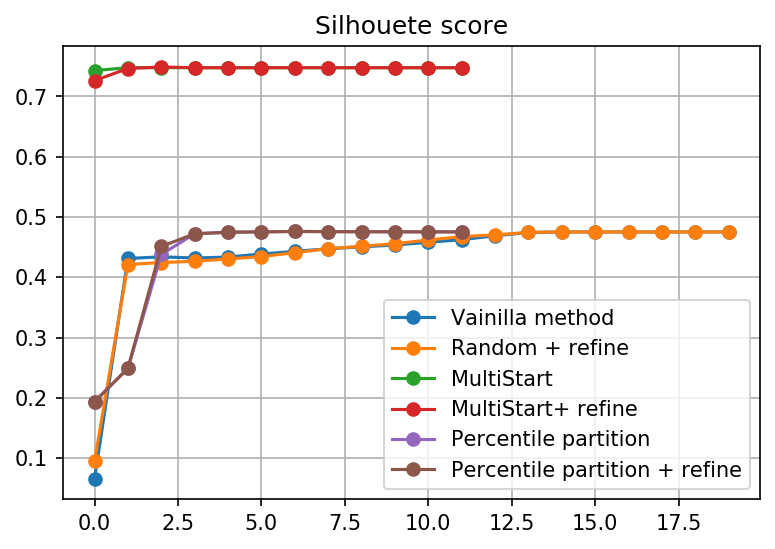

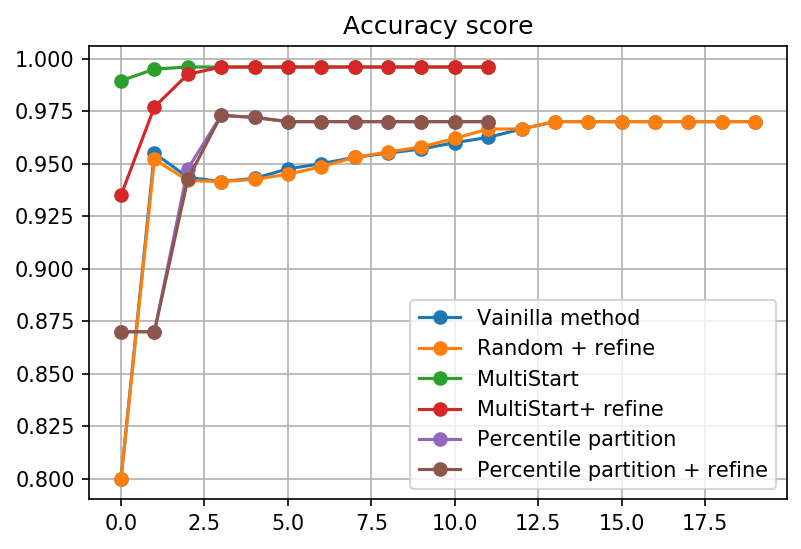

In [0]:

plt.rcParams['figure.dpi']=150

plt.plot(C1.Score, marker='o', label='Vainilla method')
plt.plot(C2.Score,marker='o', label='Random + refine')
plt.plot(C3.Score,marker='o', label='MultiStart')
plt.plot(C4.Score,marker='o', label='MultiStart+ refine')
plt.plot(C5.Score,marker='o', label='Percentile partition')
plt.plot(C6.Score,marker='o', label='Percentile partition + refine')
plt.grid(True)
plt.title("Silhouete score")
plt.legend(loc='best')


plt.show()


plt.plot(C1.Acc, marker='o', label='Vainilla method')
plt.plot(C2.Acc,marker='o', label='Random + refine')
plt.plot(C3.Acc,marker='o', label='MultiStart')
plt.plot(C4.Acc,marker='o', label='MultiStart+ refine')
plt.plot(C5.Acc,marker='o', label='Percentile partition')
plt.plot(C6.Acc,marker='o', label='Percentile partition + refine')
plt.grid(True)
plt.title("Accuracy score")
plt.legend(loc='best')


## Clustering Jerárquico

In [0]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
plt.rcParams['figure.figsize'] = [8, 8]
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

El dataset cargado tiene 1999 instancias.


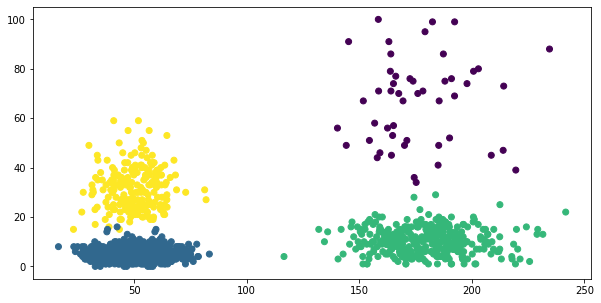

In [8]:
np.random.seed(17) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

data_file_url = 'https://raw.githubusercontent.com/flifuehu/viu-unsupervised-learning/master/datasets/sinteticos/dataset_cuatro_diferente_densidad.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]
print('El dataset cargado tiene',Dy.size,'instancias.')

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

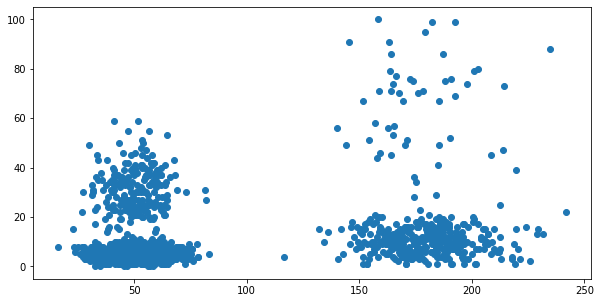

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1])

In [0]:
# generate two clusters: a with 100 points, b with 50:
np.random.seed(4711)  # for repeatability of this tutorial
a = np.random.multivariate_normal([10, 0], [[3, 1], [1, 4]], size=[100,])
b = np.random.multivariate_normal([0, 20], [[3, 1], [1, 4]], size=[50,])
X = np.concatenate((a, b),)
print(X.shape)  # 150 samples with 2 dimensions
plt.scatter(X[:,0], X[:,1])
plt.show()

In [0]:
z = linkage(Dx, method='average', metric='euclidean')

In [13]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

# pdist calcula las distancias entre elementos de nuestro dataset usando la 
# métrica indicada (euclideana por defecto)
c, cophs_dists = cophenet(z, pdist(Dx))
print(f'Cophenet coefficient: {c}')

Cophenet coefficient: 0.969207630044904


In [14]:
z[0]

array([400., 789.,   0.,   2.])

In [17]:
z[:33]

array([[ 400.,  789.,    0.,    2.],
       [ 496.,  554.,    0.,    2.],
       [ 459., 1124.,    0.,    2.],
       [1801., 1878.,    0.,    2.],
       [1009., 1272.,    0.,    2.],
       [ 410., 1310.,    0.,    2.],
       [1775., 1958.,    0.,    2.],
       [ 420., 1105.,    0.,    2.],
       [1489., 1750.,    0.,    2.],
       [  51., 1970.,    0.,    2.],
       [ 905., 1545.,    0.,    2.],
       [ 492., 1641.,    0.,    2.],
       [ 530.,  868.,    0.,    2.],
       [  85., 1736.,    0.,    2.],
       [1730., 1972.,    0.,    2.],
       [ 563.,  791.,    0.,    2.],
       [ 757., 1098.,    0.,    2.],
       [  80.,  310.,    0.,    2.],
       [ 182., 1104.,    0.,    2.],
       [  83.,  111.,    0.,    2.],
       [1079., 1088.,    0.,    2.],
       [ 355.,  761.,    0.,    2.],
       [ 440., 1108.,    0.,    2.],
       [ 753., 1758.,    0.,    2.],
       [ 303.,  809.,    0.,    2.],
       [1476., 1490.,    0.,    2.],
       [1647., 1770.,    0.,    2.],
 

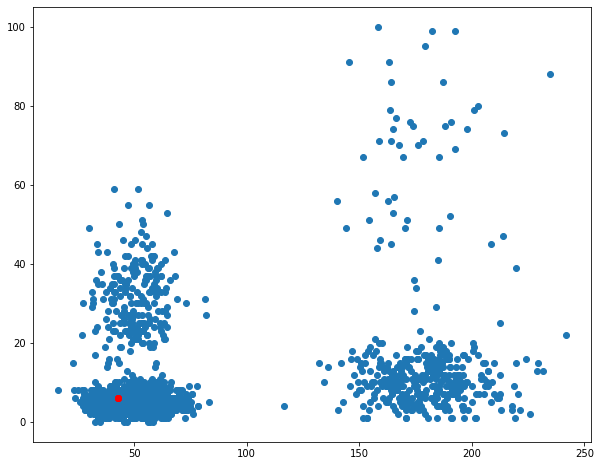

[[42.9  6. ]
 [42.9  6. ]
 [42.9  6. ]]


In [18]:
idxs = [447, 738, 1794]
plt.figure(figsize=(10, 8))
plt.scatter(Dx[:,0], Dx[:,1])  # plot all points
plt.scatter(Dx[idxs,0], Dx[idxs,1], c='r')  # plot interesting points in red again
plt.show()

print(Dx[idxs])

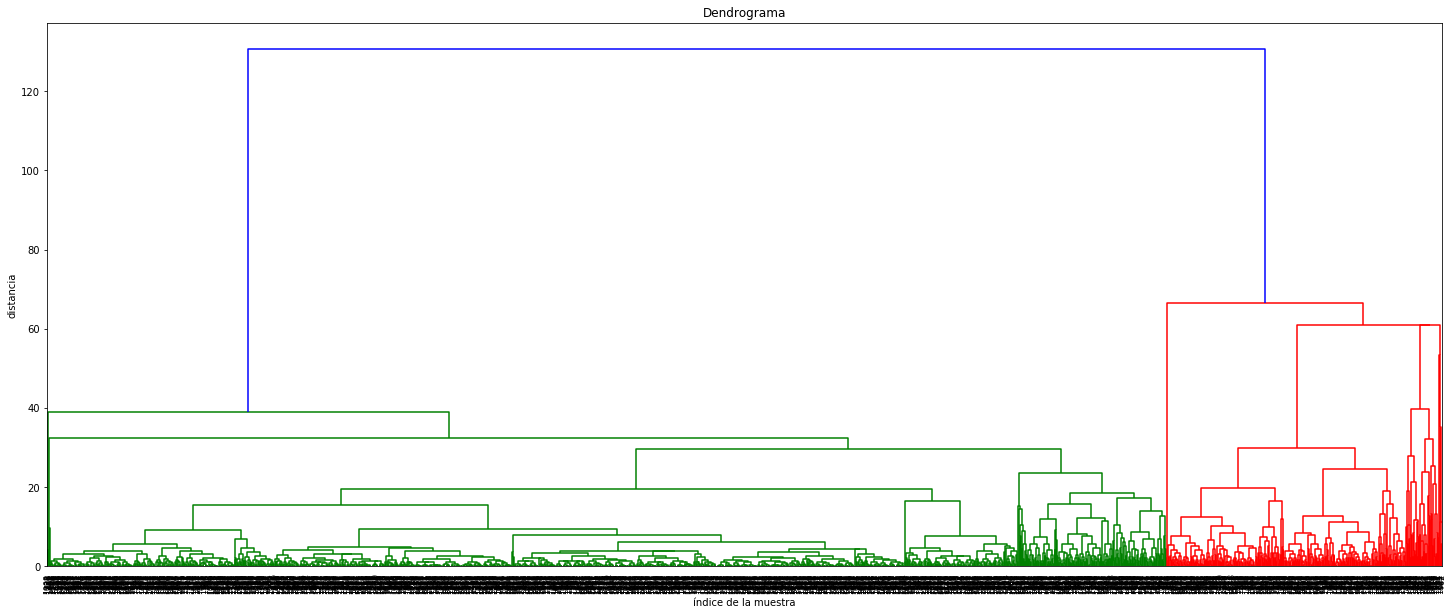

In [19]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Dendrograma')
plt.xlabel('índice de la muestra')
plt.ylabel('distancia')
dendrogram(
    z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

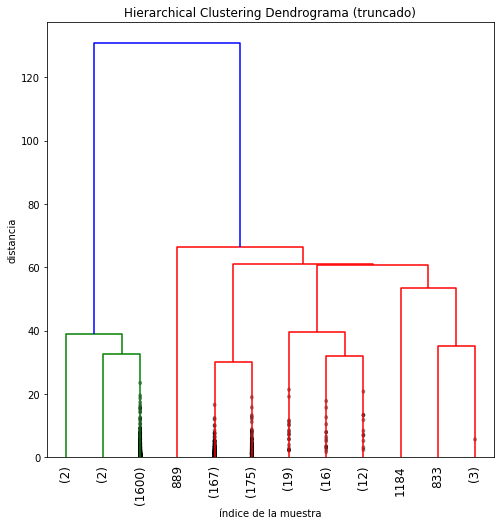

In [20]:
# quedarnos con las últimas p uniones
plt.title('Hierarchical Clustering Dendrograma (truncado)')
plt.xlabel('índice de la muestra')
plt.ylabel('distancia')
dendrogram(
    z,
    truncate_mode='lastp',  # mostrar solo las últimas p uniones
    p=12,  # definimos p
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [0]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

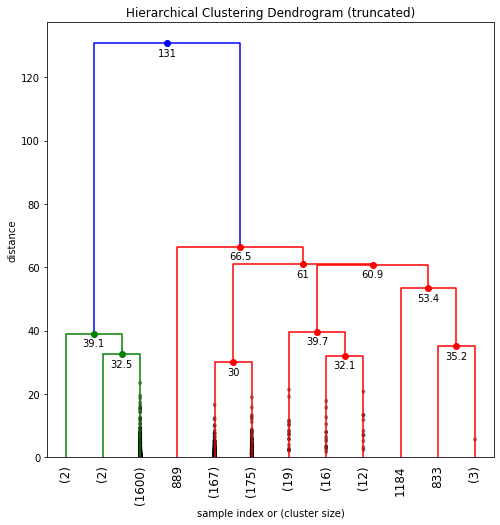

In [22]:
fancy_dendrogram(
    z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1,  # useful in small plots so annotations don't overlap
)
plt.show()

In [29]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
clusters = cluster.fit_predict(Dx)
print(clusters)

[0 0 0 ... 1 3 1]


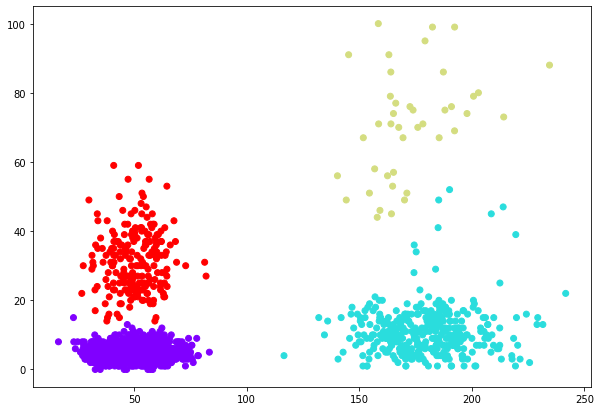

In [30]:
plt.figure(figsize=(10, 7))
plt.scatter(Dx[:,0], Dx[:,1], c=cluster.labels_, cmap='rainbow')

# Dataset 2

El dataset cargado tiene 767 instancias.


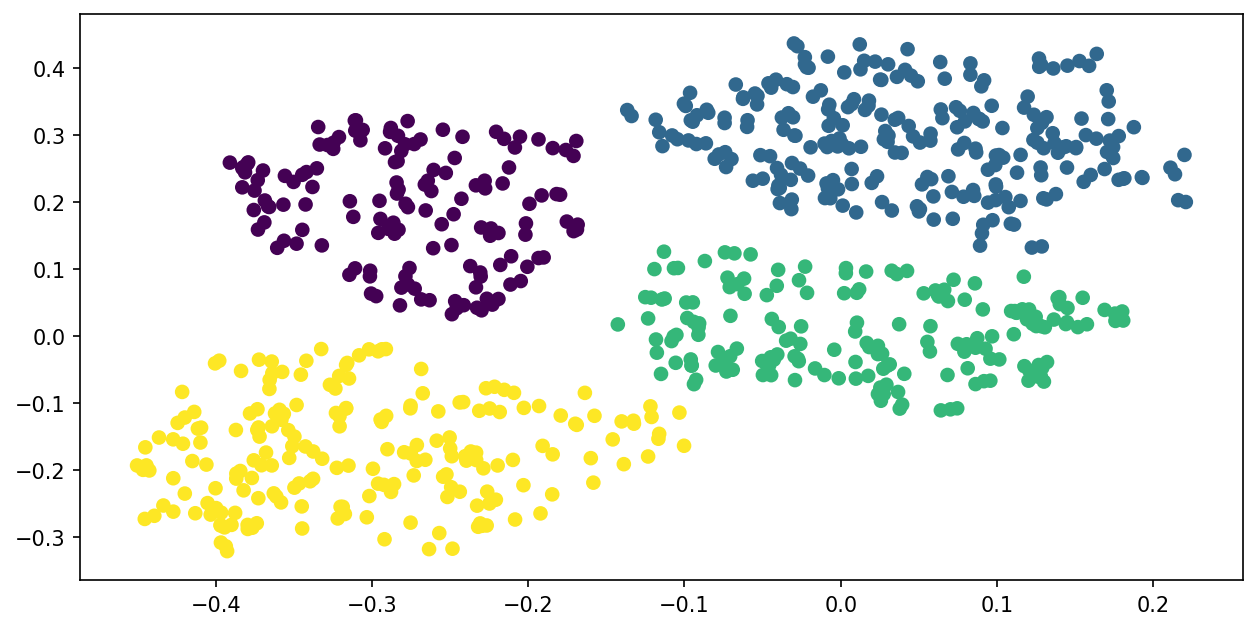

In [0]:
np.random.seed(17) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

data_file_url = 'https://raw.githubusercontent.com/flifuehu/viu-unsupervised-learning/master/datasets/sinteticos/dataset_cuatro_separables_peque.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]
print('El dataset cargado tiene',Dy.size,'instancias.')

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)










  0%|          | 0/200 [00:00<?, ?it/s]


 
 Method: Random

 
 Finished centroids initialization 




Stopped iterations at  11  iterations


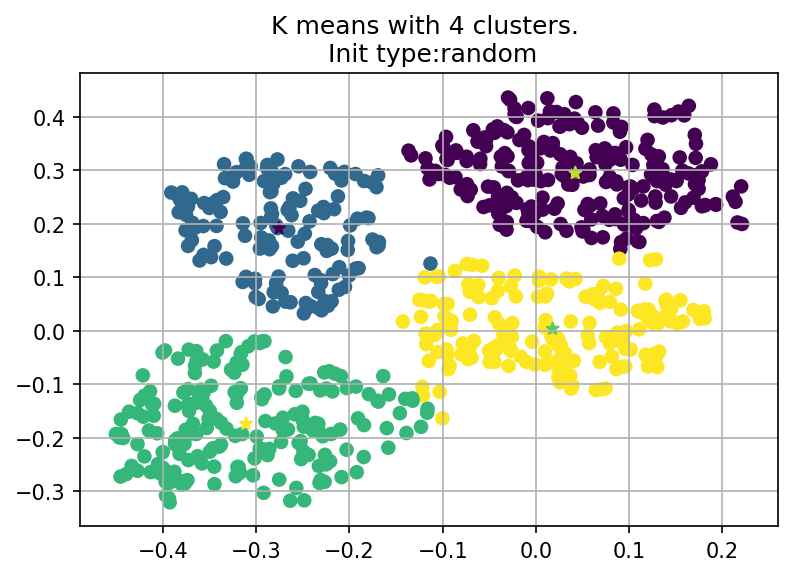










  0%|          | 0/200 [00:00<?, ?it/s]

 Silhouette score: 0.5365345760643718
Accuracy: 0.9895697522816167

 
 Method: Random + Refine

 
 Finished centroids initialization 


Called refine function


Stopped iterations at  11  iterations


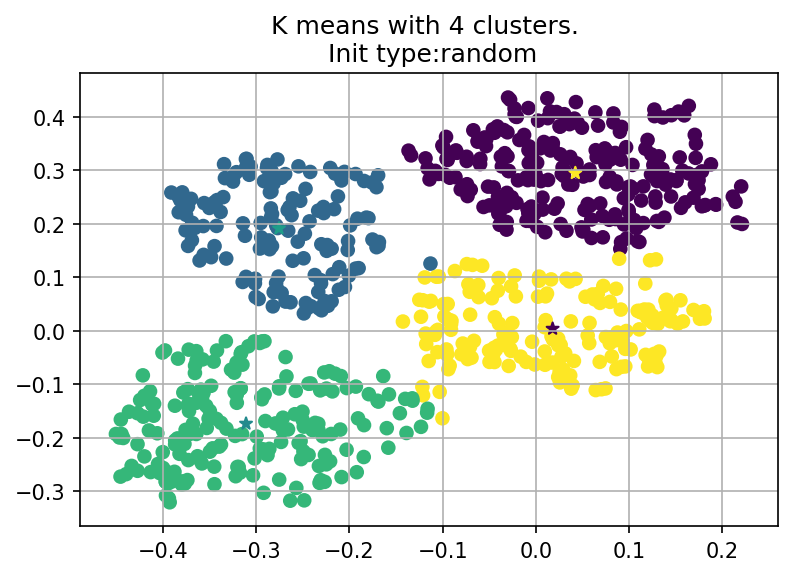










  0%|          | 0/38350 [00:00<?, ?it/s]

 Silhouette score: 0.5365345760643718
Accuracy: 0.9895697522816167

 
 Method: MultiStart
D max: 4.4380549580333515

 Finished centroids initialization 
D max: 4.974876963742606

 Finished centroids initialization 
D max: 5.547587847510746

 Finished centroids initialization 
D max: 5.757632756724654

 Finished centroids initialization 
D max: 6.507738176019775

 Finished centroids initialization 
D max: 6.595968974144755

 Finished centroids initialization 
D max: 6.685685913825559

 Finished centroids initialization 
D max: 6.720074813217087

 Finished centroids initialization 
D max: 6.729553786787594

 Finished centroids initialization 
D max: 6.929309503902321

 Finished centroids initialization 











 20%|██        | 7850/38350 [00:02<00:07, 3924.66it/s]

D max: 7.028999391316219

 Finished centroids initialization 











 42%|████▏     | 16005/38350 [00:04<00:05, 3969.27it/s]








 64%|██████▎   | 24396/38350 [00:06<00:03, 4034.50it/s]








 86%|████████▌ | 32841/38350 [00:08<00:01, 4089.05it/s]








100%|██████████| 38350/38350 [00:09<00:00, 4124.02it/s]








  0%|          | 0/200 [00:00<?, ?it/s]

[[ 0.170305   0.366495 ]
 [ 0.0637146  0.408618 ]
 [-0.39677   -0.308229 ]
 [-0.303375  -0.270487 ]]


Stopped iterations at  14  iterations


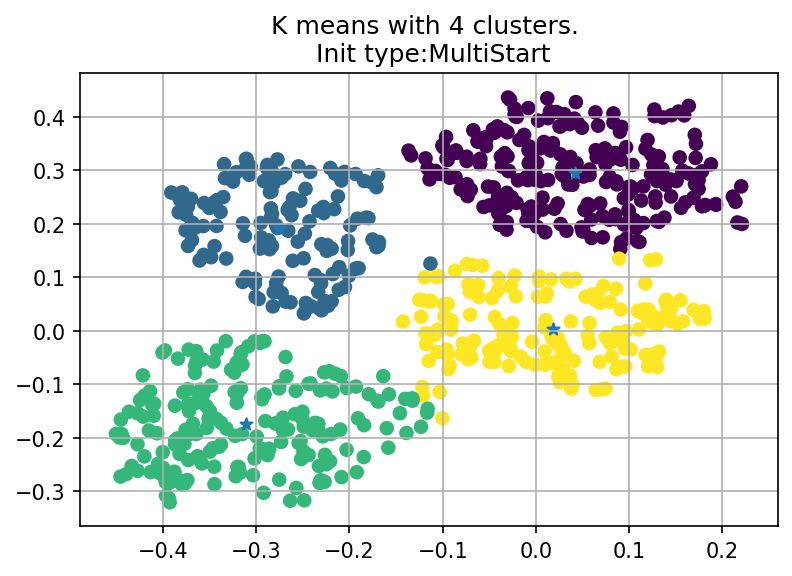










  0%|          | 0/38350 [00:00<?, ?it/s]

 Silhouette score: 0.5365345760643718
Accuracy: 0.9895697522816167

 
 Method: MultiStart + Refine
D max: 5.56584636244861

 Finished centroids initialization 
D max: 5.995529319772106

 Finished centroids initialization 
D max: 6.258439253127857

 Finished centroids initialization 
D max: 6.55174346114679

 Finished centroids initialization 
D max: 6.824618460895572

 Finished centroids initialization 
D max: 6.828725349140795

 Finished centroids initialization 











 20%|██        | 7820/38350 [00:02<00:07, 3909.44it/s]

D max: 6.945225503425805

 Finished centroids initialization 
D max: 7.041243276640736

 Finished centroids initialization 











 41%|████      | 15722/38350 [00:04<00:05, 3921.79it/s]








 62%|██████▏   | 23729/38350 [00:06<00:03, 3945.92it/s]

D max: 7.070782470725085

 Finished centroids initialization 











 83%|████████▎ | 31867/38350 [00:08<00:01, 3981.92it/s]








100%|██████████| 38350/38350 [00:09<00:00, 3986.61it/s]








  0%|          | 0/200 [00:00<?, ?it/s]

[[ 0.170305   0.366495 ]
 [ 0.175868   0.0224301]
 [-0.306005   0.307337 ]
 [-0.439394  -0.268282 ]]
Called refine function


Stopped iterations at  11  iterations


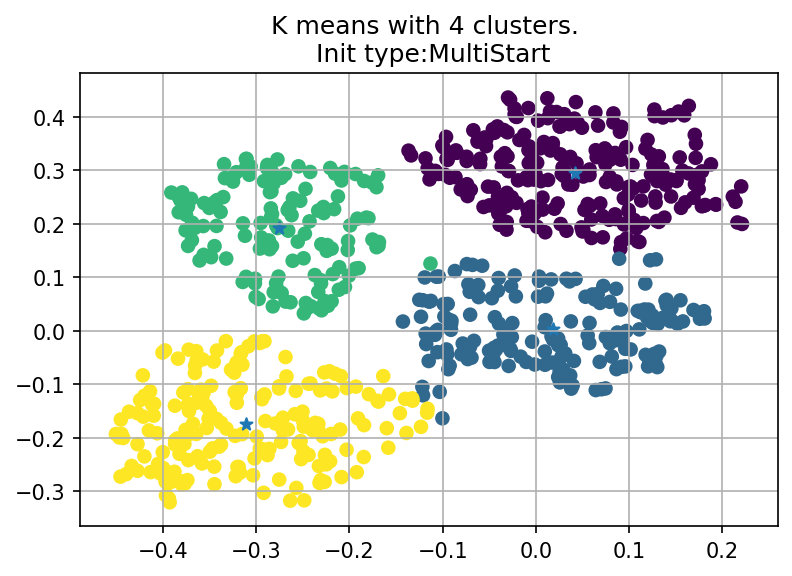










  0%|          | 0/200 [00:00<?, ?it/s]

 Silhouette score: 0.5365345760643718
Accuracy: 0.9895697522816167

 
 Method: Percentile partition

 
 Finished centroids initialization 


[[-0.323308   -0.17758669]
 [-0.2023365  -0.04113174]
 [-0.00751561  0.17862477]
 [ 0.08496326  0.28294025]]


Stopped iterations at  11  iterations


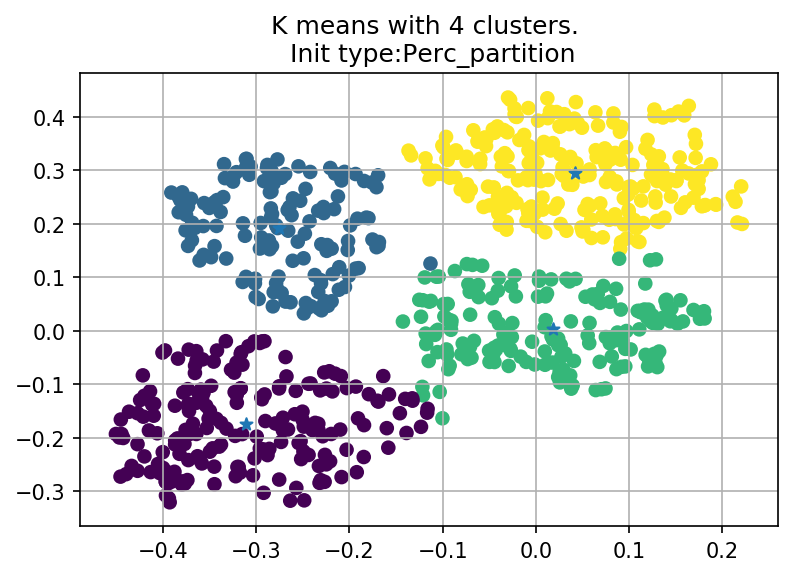










  0%|          | 0/200 [00:00<?, ?it/s]

 Silhouette score: 0.5365345760643718
Accuracy: 0.9895697522816167

 
 Method: Percentile partition + Refine

 
 Finished centroids initialization 


[[-0.323308   -0.17758669]
 [-0.2023365  -0.04113174]
 [-0.00751561  0.17862477]
 [ 0.08496326  0.28294025]]
Called refine function


Stopped iterations at  11  iterations


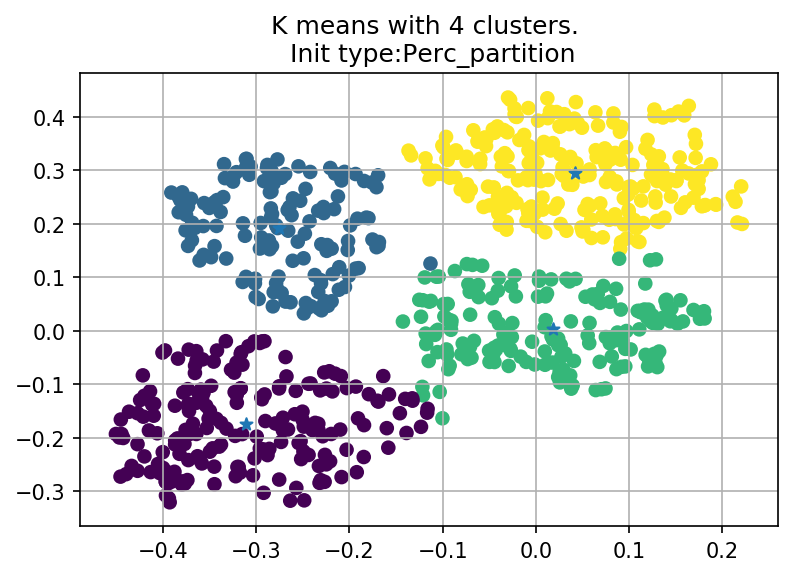

 Silhouette score: 0.5365345760643718
Accuracy: 0.9895697522816167


In [0]:

np.random.seed(5)
R=10
Clust=4

Method_Name='Random'
print("\n \n Method:", Method_Name)
C1=KMeans_VIU(K=Clust,init_type='random')
C1.fit(Dx, plot=True, Refine=False, y=Dy)

Method_Name='Random + Refine'
print("\n \n Method:", Method_Name)
C2=KMeans_VIU(K=Clust,init_type='random')
C2.fit(Dx, plot=True, Refine=True, y=Dy,Refine_interval=R)

Method_Name='MultiStart'
print("\n \n Method:", Method_Name)
C3=KMeans_VIU(K=Clust,init_type='MultiStart')
C3.fit(Dx, plot=True, Refine=False, y=Dy)

Method_Name='MultiStart + Refine'
print("\n \n Method:", Method_Name)
C4=KMeans_VIU(K=Clust,init_type='MultiStart')
C4.fit(Dx, plot=True, Refine=True, y=Dy,Refine_interval=R)

Method_Name='Percentile partition'
print("\n \n Method:", Method_Name)
C5=KMeans_VIU(K=Clust,init_type='Perc_partition')
C5.fit(Dx, plot=True, Refine=False, y=Dy)

Method_Name='Percentile partition + Refine'
print("\n \n Method:", Method_Name)
C6=KMeans_VIU(K=Clust,init_type='Perc_partition')
C6.fit(Dx, plot=True, Refine=True, y=Dy,Refine_interval=R)
       


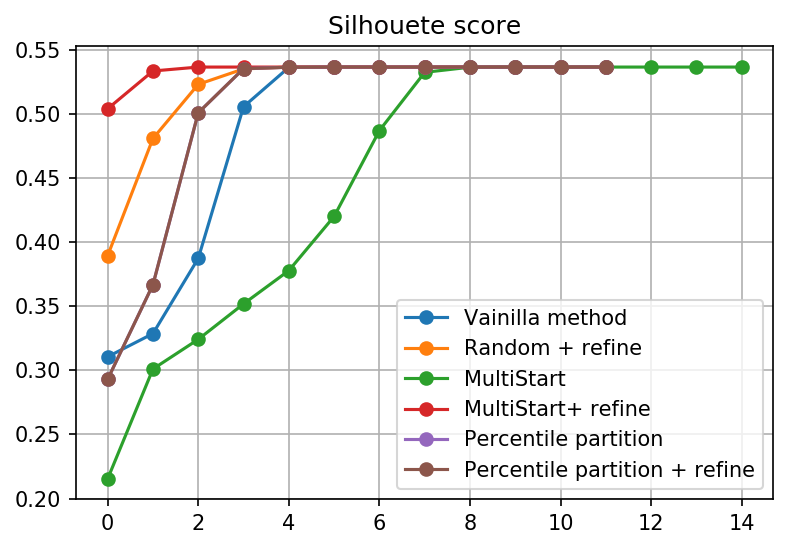

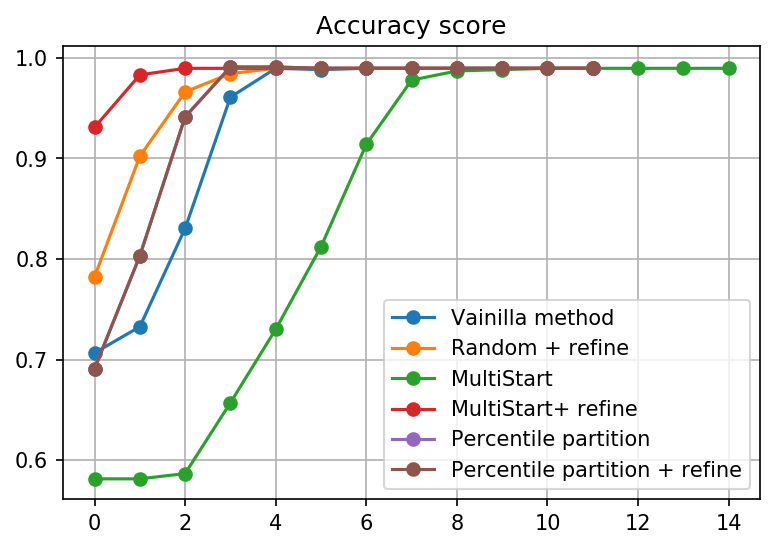

In [0]:

plt.rcParams['figure.dpi']=150

plt.plot(C1.Score, marker='o', label='Vainilla method')
plt.plot(C2.Score,marker='o', label='Random + refine')
plt.plot(C3.Score,marker='o', label='MultiStart')
plt.plot(C4.Score,marker='o', label='MultiStart+ refine')
plt.plot(C5.Score,marker='o', label='Percentile partition')
plt.plot(C6.Score,marker='o', label='Percentile partition + refine')
plt.grid(True)
plt.title("Silhouete score")
plt.legend(loc='best')


plt.show()


plt.plot(C1.Acc, marker='o', label='Vainilla method')
plt.plot(C2.Acc,marker='o', label='Random + refine')
plt.plot(C3.Acc,marker='o', label='MultiStart')
plt.plot(C4.Acc,marker='o', label='MultiStart+ refine')
plt.plot(C5.Acc,marker='o', label='Percentile partition')
plt.plot(C6.Acc,marker='o', label='Percentile partition + refine')
plt.grid(True)
plt.title("Accuracy score")
plt.legend(loc='best')


## **PCA**

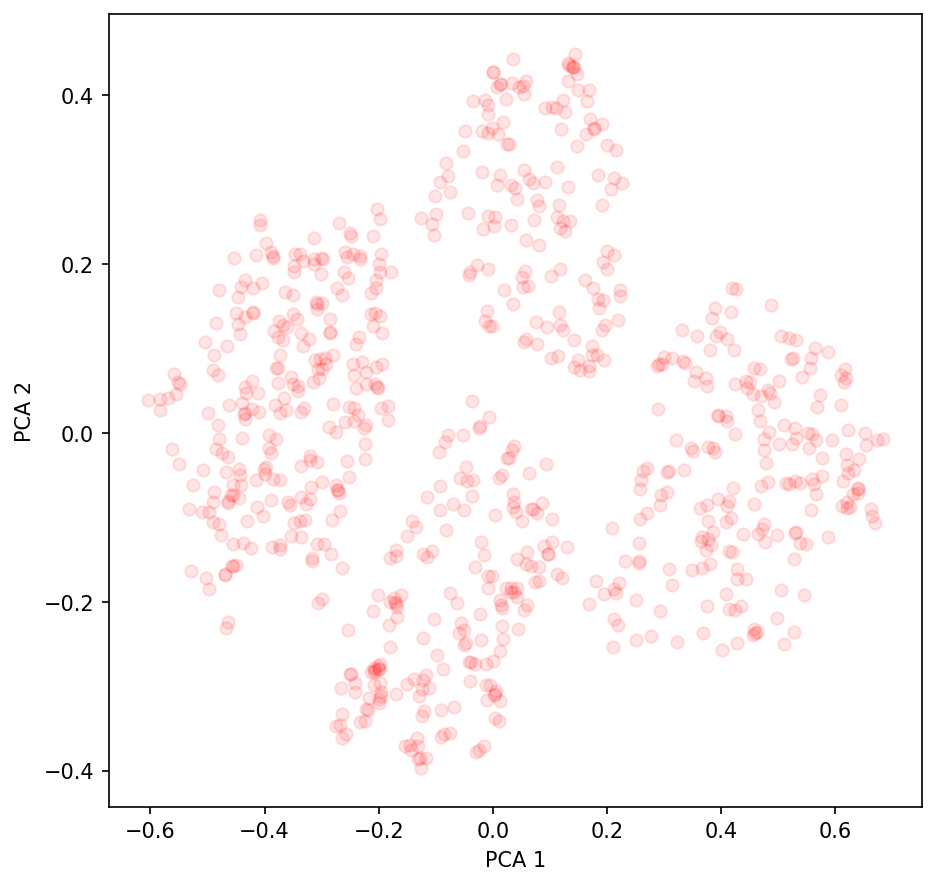

In [0]:
import sklearn.preprocessing
from sklearn.decomposition import PCA

scalerDx = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
Xp = scalerDx.fit_transform(Dx)
porcentajeVE = 0.95
sklearn_pca = PCA(porcentajeVE)

pComponents = sklearn_pca.fit_transform(Xp)

plt.figure(figsize = (7,7))
plt.scatter(pComponents[:,0], pComponents[:,1], c= 'r', alpha=.1) 
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

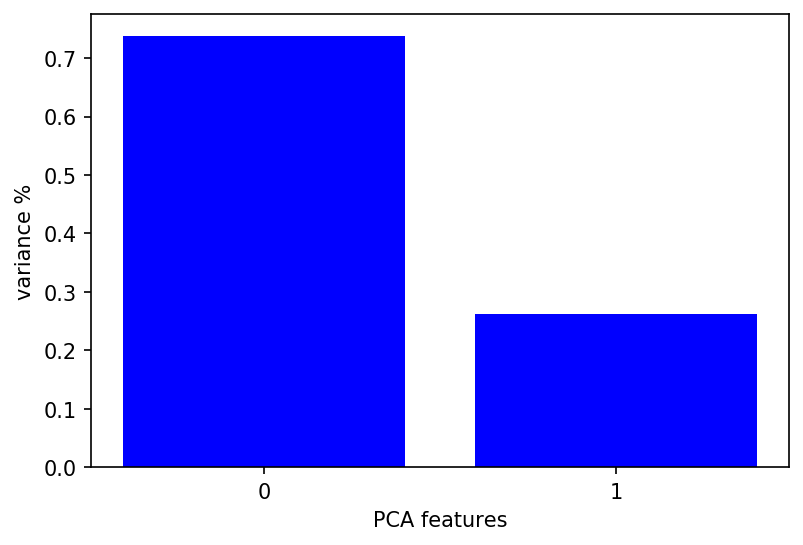

In [0]:
# Plot the explained variances
features = range(sklearn_pca.n_components_)
plt.bar(features, sklearn_pca.explained_variance_ratio_, color='b')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
#pca_comp = pd.DataFrame(pComponents)









  0%|          | 0/200 [00:00<?, ?it/s]


 
 Method: Random

 
 Finished centroids initialization 




Stopped iterations at  11  iterations


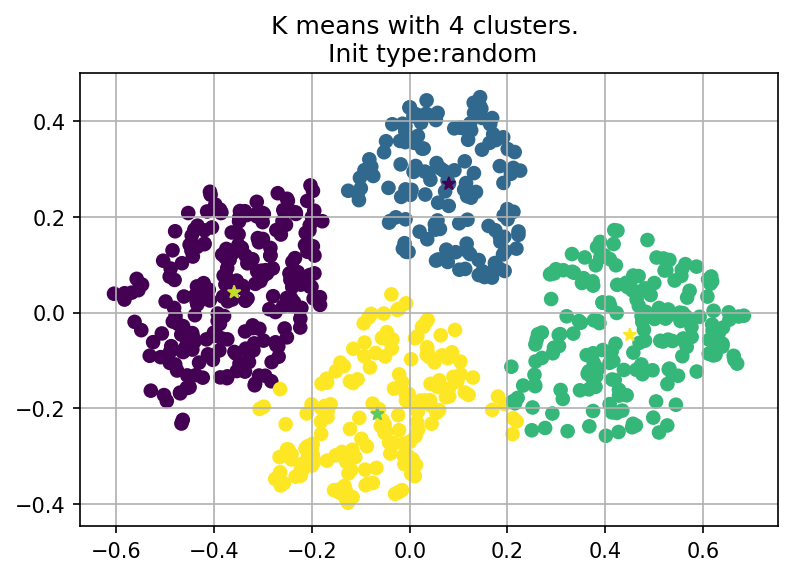









  0%|          | 0/200 [00:00<?, ?it/s]

 Silhouette score: 0.5271573004031296
Accuracy: 0.9882659713168188

 
 Method: Random + Refine

 
 Finished centroids initialization 


Called refine function


Stopped iterations at  11  iterations


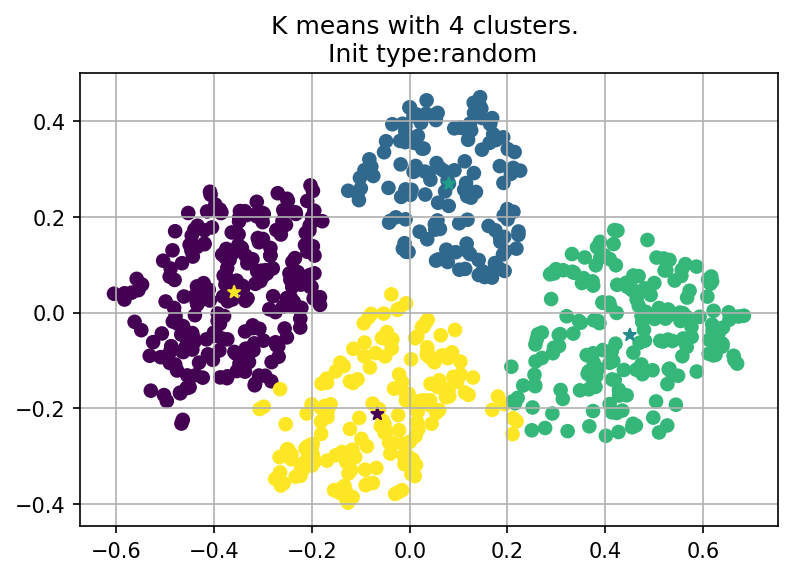









  0%|          | 0/38350 [00:00<?, ?it/s]

 Silhouette score: 0.5271573004031296
Accuracy: 0.9882659713168188

 
 Method: MultiStart
D max: 6.160960832915209

 Finished centroids initialization 
D max: 6.808263836927365

 Finished centroids initialization 
D max: 7.718316852573391

 Finished centroids initialization 
D max: 8.06502320319553

 Finished centroids initialization 
D max: 9.010058958673685

 Finished centroids initialization 
D max: 9.041554895392727

 Finished centroids initialization 
D max: 9.09956965796916

 Finished centroids initialization 
D max: 9.202301623757407

 Finished centroids initialization 
D max: 9.305642624143236

 Finished centroids initialization 
D max: 9.435711923101863

 Finished centroids initialization 
D max: 9.601685481082399

 Finished centroids initialization 










 19%|█▊        | 7098/38350 [00:02<00:08, 3548.53it/s]

D max: 9.637306678861778

 Finished centroids initialization 
D max: 9.721522301645368

 Finished centroids initialization 










 40%|███▉      | 15198/38350 [00:04<00:06, 3685.41it/s]

D max: 9.728194246275375

 Finished centroids initialization 










 61%|██████▏   | 23534/38350 [00:06<00:03, 3817.93it/s]







 83%|████████▎ | 31654/38350 [00:08<00:01, 3887.34it/s]

D max: 9.793211514858331

 Finished centroids initialization 










100%|██████████| 38350/38350 [00:09<00:00, 3983.37it/s]







  0%|          | 0/200 [00:00<?, ?it/s]

[[ 0.68380198 -0.00653918]
 [-0.56877857  0.04157345]
 [-0.01086904 -0.31620447]
 [ 0.14833675  0.40593378]]


Stopped iterations at  11  iterations


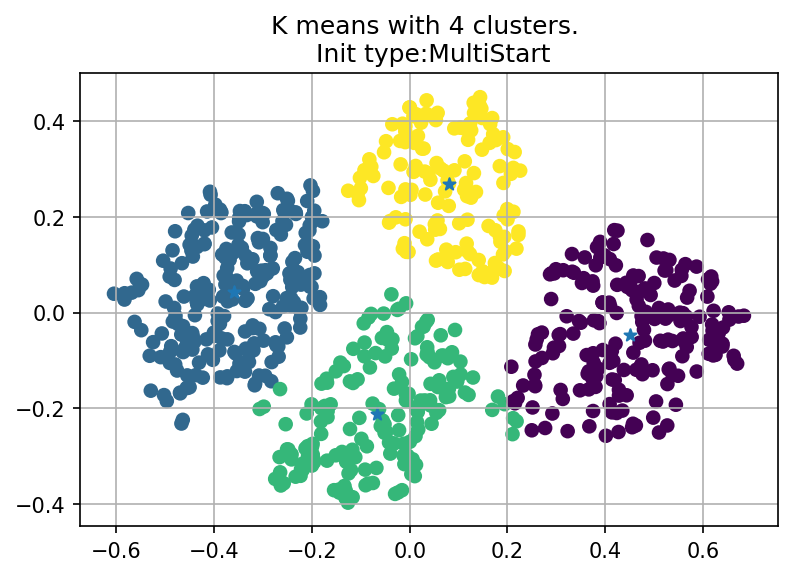









  0%|          | 0/38350 [00:00<?, ?it/s]

 Silhouette score: 0.5271573004031296
Accuracy: 0.9882659713168188

 
 Method: MultiStart + Refine
D max: 7.770680151681689

 Finished centroids initialization 
D max: 8.453646505234078

 Finished centroids initialization 
D max: 8.73782702131463

 Finished centroids initialization 
D max: 9.092142706534139

 Finished centroids initialization 
D max: 9.399927396890462

 Finished centroids initialization 
D max: 9.546917528042002

 Finished centroids initialization 










 21%|██        | 8041/38350 [00:02<00:07, 4020.42it/s]

D max: 9.677100158602848

 Finished centroids initialization 
D max: 9.854444571768736

 Finished centroids initialization 










 42%|████▏     | 16271/38350 [00:04<00:05, 4048.31it/s]

D max: 9.987086991023547

 Finished centroids initialization 










 64%|██████▍   | 24517/38350 [00:06<00:03, 4070.36it/s]







 86%|████████▌ | 32853/38350 [00:08<00:01, 4099.14it/s]







100%|██████████| 38350/38350 [00:09<00:00, 4116.83it/s]







  0%|          | 0/200 [00:00<?, ?it/s]

[[-0.56285106 -0.01941696]
 [-0.25774276 -0.35615277]
 [ 0.0076151   0.40953081]
 [ 0.67293638 -0.00826677]]
Called refine function
Stopped iterations at  11  iterations


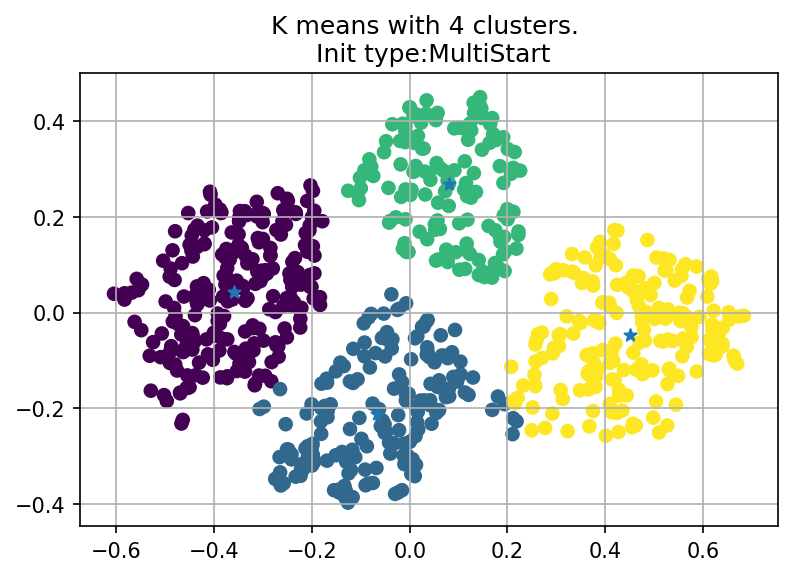










  0%|          | 0/200 [00:00<?, ?it/s]

 Silhouette score: 0.5271573004031296
Accuracy: 0.9882659713168188

 
 Method: Percentile partition

 
 Finished centroids initialization 


[[-0.27454348 -0.1796686 ]
 [-0.17007993 -0.1111033 ]
 [ 0.11326333  0.07487081]
 [ 0.250607    0.16501718]]


Stopped iterations at  11  iterations


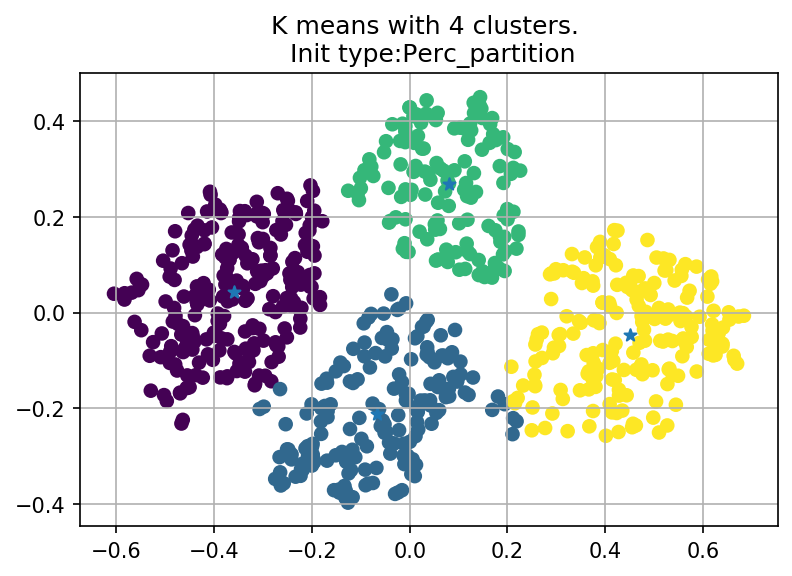










  0%|          | 0/200 [00:00<?, ?it/s]

 Silhouette score: 0.5271573004031296
Accuracy: 0.9882659713168188

 
 Method: Percentile partition + Refine

 
 Finished centroids initialization 


[[-0.27454348 -0.1796686 ]
 [-0.17007993 -0.1111033 ]
 [ 0.11326333  0.07487081]
 [ 0.250607    0.16501718]]
Called refine function


Stopped iterations at  11  iterations


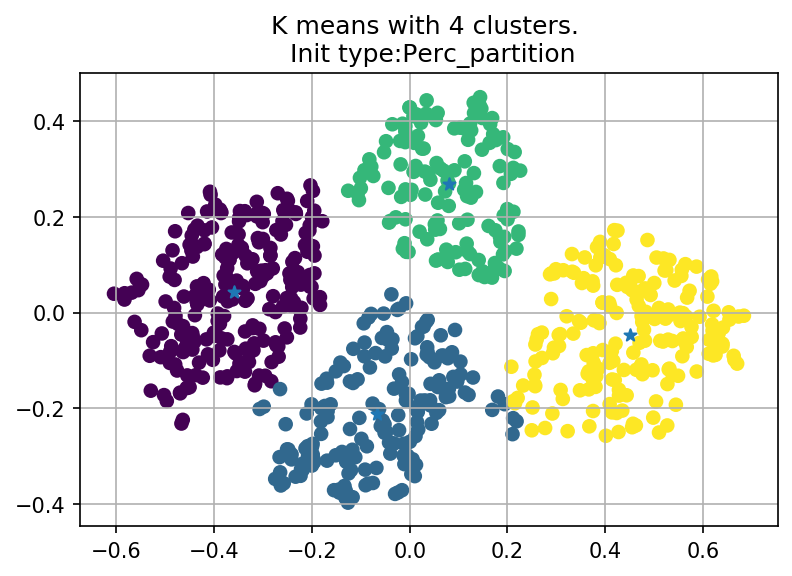

 Silhouette score: 0.5271573004031296
Accuracy: 0.9882659713168188


In [0]:

np.random.seed(5)
R=10
Clust=4


Method_Name='Random'
print("\n \n Method:", Method_Name)
C1=KMeans_VIU(K=Clust,init_type='random')
C1.fit(pComponents, plot=True, Refine=False, y=Dy)

Method_Name='Random + Refine'
print("\n \n Method:", Method_Name)
C2=KMeans_VIU(K=Clust,init_type='random')
C2.fit(pComponents, plot=True, Refine=True, y=Dy,Refine_interval=R)

Method_Name='MultiStart'
print("\n \n Method:", Method_Name)
C3=KMeans_VIU(K=Clust,init_type='MultiStart')
C3.fit(pComponents, plot=True, Refine=False, y=Dy)

Method_Name='MultiStart + Refine'
print("\n \n Method:", Method_Name)
C4=KMeans_VIU(K=Clust,init_type='MultiStart')
C4.fit(pComponents, plot=True, Refine=True, y=Dy,Refine_interval=R)

Method_Name='Percentile partition'
print("\n \n Method:", Method_Name)
C5=KMeans_VIU(K=Clust,init_type='Perc_partition')
C5.fit(pComponents, plot=True, Refine=False, y=Dy)

Method_Name='Percentile partition + Refine'
print("\n \n Method:", Method_Name)
C6=KMeans_VIU(K=Clust,init_type='Perc_partition')
C6.fit(pComponents, plot=True, Refine=True, y=Dy,Refine_interval=R)
       


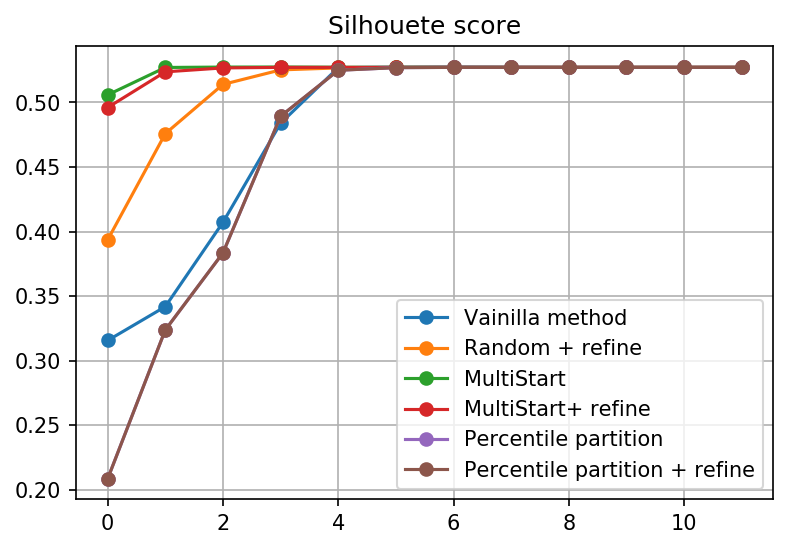

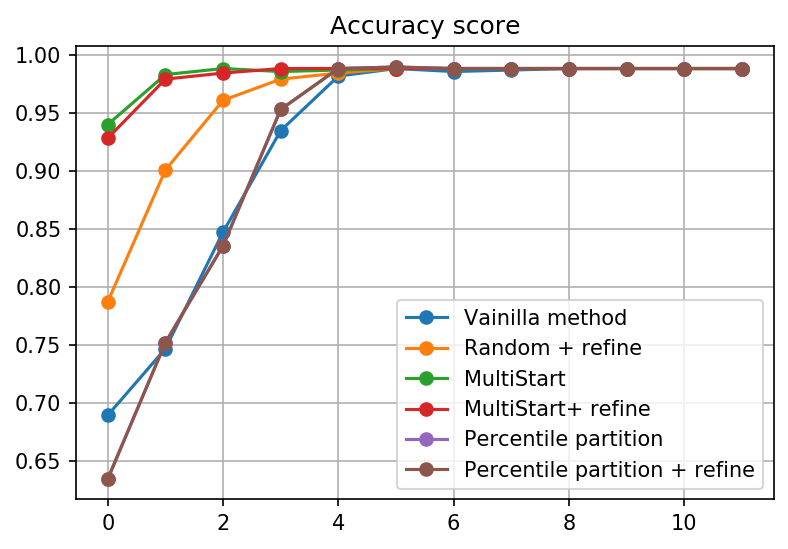

In [0]:

plt.rcParams['figure.dpi']=150

plt.plot(C1.Score, marker='o', label='Vainilla method')
plt.plot(C2.Score,marker='o', label='Random + refine')
plt.plot(C3.Score,marker='o', label='MultiStart')
plt.plot(C4.Score,marker='o', label='MultiStart+ refine')
plt.plot(C5.Score,marker='o', label='Percentile partition')
plt.plot(C6.Score,marker='o', label='Percentile partition + refine')
plt.grid(True)
plt.title("Silhouete score")
plt.legend(loc='best')


plt.show()


plt.plot(C1.Acc, marker='o', label='Vainilla method')
plt.plot(C2.Acc,marker='o', label='Random + refine')
plt.plot(C3.Acc,marker='o', label='MultiStart')
plt.plot(C4.Acc,marker='o', label='MultiStart+ refine')
plt.plot(C5.Acc,marker='o', label='Percentile partition')
plt.plot(C6.Acc,marker='o', label='Percentile partition + refine')
plt.grid(True)
plt.title("Accuracy score")
plt.legend(loc='best')


# Dataset 3
 En este dataset sintetico en especifico se pone a prueba las variaciones de los algoritmos respecto a datasets con una gran cantidad de centroides.

In [0]:
np.random.seed(17)
Dx, Dy = make_blobs(n_samples=2000, n_features=3, centers=12)

print("Dx shape;:::",Dx.shape)
np.random.seed(5)
R=5
Clust=12
try:
  Method_Name='Random'
  print("\n \n Method:", Method_Name)
  C1=KMeans_VIU(K=Clust,init_type='random')
  C1.fit(Dx, plot=True, Refine=False, y=Dy)
except:
  print("Did not find convergence on method"+ Method_Name)

try:
  Method_Name='Random + Refine'
  print("\n \n Method:", Method_Name)
  C2=KMeans_VIU(K=Clust,init_type='random')
  C2.fit(Dx, plot=True, Refine=True, y=Dy,Refine_interval=R)
except:
  print("Did not find convergence on method"+ Method_Name)

try:
  Method_Name='MultiStart'
  print("\n \n Method:", Method_Name)
  C3=KMeans_VIU(K=Clust,init_type='MultiStart')
  C3.fit(Dx, plot=True, Refine=False, y=Dy)

except:
  print("Did not find convergence on method"+ Method_Name)

try:
  Method_Name='MultiStart + Refine'
  print("\n \n Method:", Method_Name)
  C4=KMeans_VIU(K=Clust,init_type='MultiStart')
  C4.fit(Dx, plot=True, Refine=True, y=Dy,Refine_interval=R)
except:
  print("Did not find convergence on method"+ Method_Name)

try:
  Method_Name='Percentile partition'
  print("\n \n Method:", Method_Name)
  C5=KMeans_VIU(K=Clust,init_type='Perc_partition')
  C5.fit(Dx, plot=True, Refine=False, y=Dy)
except:
  print("Did not find convergence on method"+ Method_Name)

try:
  Method_Name='Percentile partition + Refine'
  print("\n \n Method:", Method_Name)
  C6=KMeans_VIU(K=Clust,init_type='Perc_partition')
  C6.fit(Dx, plot=True, Refine=True, y=Dy,Refine_interval=R)

except:
  print("Did not find convergence on method"+ Method_Name)


       











  0%|          | 0/200 [00:00<?, ?it/s]

Dx shape;::: (2000, 3)

 
 Method: Random

 
 Finished centroids initialization 














  0%|          | 0/200 [00:00<?, ?it/s]

Stopped iterations at  15  iterations
Cannot plot something diferent to 2D
 Silhouette score: 0.5031939464369233
Accuracy: 0.8265

 
 Method: Random + Refine

 
 Finished centroids initialization 


Called refine function












  2%|▎         | 5/200 [00:19<12:53,  3.97s/it]

Called refine function












  2%|▎         | 5/200 [00:38<12:53,  3.97s/it]









  5%|▌         | 10/200 [00:39<12:29,  3.95s/it]










  0%|          | 0/100000 [00:00<?, ?it/s]

Stopped iterations at  11  iterations
Cannot plot something diferent to 2D
 Silhouette score: 0.5375602614405626
Accuracy: 0.9065

 
 Method: MultiStart
D max: 1473.0255311858295

 Finished centroids initialization 
D max: 1683.4153795668992

 Finished centroids initialization 
D max: 1717.1905946114446

 Finished centroids initialization 
D max: 1741.2702313363866

 Finished centroids initialization 
D max: 1788.637817651851

 Finished centroids initialization 
D max: 1803.1546289957855

 Finished centroids initialization 
D max: 1844.509354169035

 Finished centroids initialization 
D max: 1846.6681025121609

 Finished centroids initialization 
D max: 1868.8453574330929

 Finished centroids initialization 













  1%|          | 1237/100000 [00:02<02:39, 618.37it/s]

D max: 1875.4620903160785

 Finished centroids initialization 
D max: 1889.3206524677444

 Finished centroids initialization 













  3%|▎         | 2528/100000 [00:04<02:35, 626.19it/s]










  4%|▍         | 3821/100000 [00:06<02:32, 632.09it/s]










  5%|▌         | 5101/100000 [00:08<02:29, 634.41it/s]










  6%|▋         | 6394/100000 [00:10<02:26, 637.95it/s]










  8%|▊         | 7696/100000 [00:12<02:23, 641.68it/s]

D max: 1895.7515304136941

 Finished centroids initialization 













  9%|▉         | 9004/100000 [00:14<02:21, 645.29it/s]










 10%|█         | 10312/100000 [00:16<02:18, 647.74it/s]










 12%|█▏        | 11636/100000 [00:18<02:15, 651.95it/s]









  5%|▌         | 10/200 [00:58<12:29,  3.95s/it]










 13%|█▎        | 12891/100000 [00:20<02:15, 644.31it/s]

D max: 1930.8644616401327

 Finished centroids initialization 













 14%|█▍        | 14146/100000 [00:22<02:14, 638.85it/s]

D max: 1931.7353198367368

 Finished centroids initialization 













 15%|█▌        | 15420/100000 [00:24<02:12, 638.25it/s]










 17%|█▋        | 16718/100000 [00:26<02:09, 641.33it/s]










 18%|█▊        | 17990/100000 [00:28<02:08, 639.64it/s]










 19%|█▉        | 19310/100000 [00:30<02:05, 645.51it/s]

D max: 1940.1107688727761

 Finished centroids initialization 
D max: 1940.1622813530807

 Finished centroids initialization 













 21%|██        | 20596/100000 [00:32<02:03, 641.22it/s]










 22%|██▏       | 21880/100000 [00:34<02:01, 641.40it/s]










 23%|██▎       | 23161/100000 [00:36<01:59, 640.76it/s]










 24%|██▍       | 24456/100000 [00:38<01:57, 642.68it/s]










 26%|██▌       | 25768/100000 [00:40<01:54, 646.55it/s]










 27%|██▋       | 27061/100000 [00:42<01:53, 644.19it/s]










 28%|██▊       | 28349/100000 [00:44<01:51, 639.96it/s]










 30%|██▉       | 29629/100000 [00:46<01:51, 632.42it/s]










 31%|███       | 30895/100000 [00:48<01:49, 630.77it/s]










 32%|███▏      | 32212/100000 [00:50<01:46, 638.80it/s]

D max: 1963.2307580079519

 Finished centroids initialization 













 33%|███▎      | 33491/100000 [00:52<01:44, 638.77it/s]










 35%|███▍      | 34803/100000 [00:54<01:41, 643.76it/s]










 36%|███▌      | 36110/100000 [00:56<01:38, 646.58it/s]










 37%|███▋      | 37404/100000 [00:58<01:36, 646.35it/s]










 39%|███▊      | 38700/100000 [01:00<01:34, 646.72it/s]










 40%|████      | 40006/100000 [01:02<01:32, 648.50it/s]










 41%|████▏     | 41304/100000 [01:04<01:30, 648.57it/s]










 43%|████▎     | 42614/100000 [01:06<01:28, 650.36it/s]










 44%|████▍     | 43915/100000 [01:08<01:26, 649.53it/s]










 45%|████▌     | 45215/100000 [01:10<01:24, 649.23it/s]










 47%|████▋     | 46530/100000 [01:12<01:22, 651.64it/s]










 48%|████▊     | 47850/100000 [01:14<01:19, 654.12it/s]










 49%|████▉     | 49159/100000 [01:16<01:17, 653.23it/s]










 50%|█████     | 50487/100000 [01:18<01:15, 656.42it/s]










 52%|█████▏    | 51801/100000 [01:20<01:13, 656.53it/s]











[[  0.31162266  -1.03401802   6.02645528]
 [ -1.09697448  -3.01013611   7.19872552]
 [ -3.54612949   9.75885579  -7.76959709]
 [ -9.87628543   4.89343667  -4.15244397]
 [  2.44947215  -2.03009759   6.05484206]
 [ -4.65242251   8.9570325   -8.50961415]
 [  8.76435489   7.05778298  -9.51484434]
 [-11.19186921   7.20552642   4.17458001]
 [  3.01228943   1.74009985  -9.40612498]
 [ -3.20739867  10.71770207  -8.97416578]
 [ -0.53393421  -9.55433741  -7.81077849]
 [ -1.80100147  -8.58211604  -6.10236157]]
























  0%|          | 0/100000 [00:00<?, ?it/s]

Stopped iterations at  18  iterations
Cannot plot something diferent to 2D
 Silhouette score: 0.4904037137832907
Accuracy: 0.7395

 
 Method: MultiStart + Refine
D max: 1750.6527575636092

 Finished centroids initialization 
D max: 1759.8611524806352

 Finished centroids initialization 
D max: 1774.036653912119

 Finished centroids initialization 
D max: 1788.4406500815696

 Finished centroids initialization 
D max: 1902.6509633049666

 Finished centroids initialization 
D max: 1908.7116216916047

 Finished centroids initialization 













  1%|▏         | 1280/100000 [00:02<02:34, 639.71it/s]










  3%|▎         | 2582/100000 [00:04<02:31, 642.96it/s]










  4%|▍         | 3908/100000 [00:06<02:28, 648.75it/s]










  5%|▌         | 5197/100000 [00:08<02:26, 647.37it/s]










  6%|▋         | 6493/100000 [00:10<02:24, 647.42it/s]










  8%|▊         | 7809/100000 [00:12<02:21, 650.42it/s]










  9%|▉         | 9131/100000 [00:14<02:19, 653.48it/s]










 10%|█         | 10465/100000 [00:16<02:16, 657.45it/s]










 12%|█▏        | 11755/100000 [00:18<02:15, 653.65it/s]










 13%|█▎        | 13021/100000 [00:20<02:14, 647.23it/s]










 14%|█▍        | 14306/100000 [00:22<02:12, 645.70it/s]










 16%|█▌        | 15591/100000 [00:24<02:10, 644.71it/s]










 17%|█▋        | 16890/100000 [00:26<02:08, 646.11it/s]










 18%|█▊        | 18171/100000 [00:28<02:06, 644.41it/s]










 19%|█▉        | 19479/100000 [00:30<02:04, 647.19it/s]

D max: 1914.8791139973944

 Finished centroids initialization 













 21%|██        | 20768/100000 [00:32<02:02, 646.03it/s]










 22%|██▏       | 22091/100000 [00:34<01:59, 650.49it/s]










 23%|██▎       | 23390/100000 [00:36<01:58, 647.80it/s]










 25%|██▍       | 24702/100000 [00:38<01:55, 650.21it/s]










 26%|██▌       | 26020/100000 [00:40<01:53, 652.72it/s]










 27%|██▋       | 27325/100000 [00:42<01:51, 650.88it/s]










 29%|██▊       | 28645/100000 [00:44<01:49, 653.46it/s]










 30%|██▉       | 29952/100000 [00:46<01:47, 651.99it/s]










 31%|███▏      | 31263/100000 [00:48<01:45, 652.95it/s]

D max: 1963.6794254604824

 Finished centroids initialization 













 33%|███▎      | 32569/100000 [00:50<01:43, 652.36it/s]










 34%|███▍      | 33874/100000 [00:52<01:41, 649.79it/s]










 35%|███▌      | 35206/100000 [00:54<01:38, 654.55it/s]










 37%|███▋      | 36533/100000 [00:56<01:36, 657.09it/s]










 38%|███▊      | 37857/100000 [00:58<01:34, 658.51it/s]










 39%|███▉      | 39185/100000 [01:00<01:32, 660.07it/s]










 41%|████      | 40506/100000 [01:02<01:30, 657.36it/s]










 42%|████▏     | 41835/100000 [01:04<01:28, 659.38it/s]










 43%|████▎     | 43154/100000 [01:06<01:26, 657.00it/s]










 44%|████▍     | 44469/100000 [01:08<01:24, 655.78it/s]










 46%|████▌     | 45792/100000 [01:10<01:22, 657.39it/s]










 47%|████▋     | 47107/100000 [01:12<01:20, 655.09it/s]










 48%|████▊     | 48427/100000 [01:14<01:18, 656.44it/s]










 50%|████▉     | 49740/100000 [01:16<01:16, 656.24it/s]










 51%|█████     | 51053/100000 [01:18<01:14, 656.02it/s]











[[  8.10410794   7.74371782 -11.64231923]
 [ -8.48155695   5.45198055   3.3166711 ]
 [ -3.59309935   5.97850958   0.88008909]
 [ -8.55798862   3.48785357  -4.61979984]
 [  1.78728207  -2.78357372   6.31951398]
 [ -9.1395969    5.9792659    4.66842042]
 [  1.40075165  -2.3477411    7.18177262]
 [  9.14962368   8.36226108  -8.62053848]
 [ -3.50224705  -6.1923697   -7.46978229]
 [ -2.3102606   -9.24054911  -8.19078595]
 [ -3.64300285   8.63832672  -8.83106212]
 [  2.32743757  -2.71250092   7.10702863]]
Called refine function
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!













  2%|▎         | 5/200 [00:18<12:04,  3.71s/it]

Called refine function
!!!!!!!!!Switched between clusters !!!!!!!!!!













  2%|▎         | 5/200 [00:30<12:04,  3.71s/it]










  5%|▌         | 10/200 [00:38<12:00,  3.79s/it]

Called refine function
!!!!!!!!!Switched between clusters !!!!!!!!!!













  5%|▌         | 10/200 [00:50<12:00,  3.79s/it]










  8%|▊         | 15/200 [00:56<11:32,  3.74s/it]











  0%|          | 0/200 [00:00<?, ?it/s]

Stopped iterations at  15  iterations
Cannot plot something diferent to 2D
 Silhouette score: 0.5017472921918718
Accuracy: 0.901

 
 Method: Percentile partition

 
 Finished centroids initialization 


[[-3.03860688 -0.89290018 -3.81135702]
 [-3.08122418 -0.93496538 -3.85326402]
 [-2.84366441 -0.70048317 -3.61966365]
 [-2.66645984 -0.52557427 -3.44541256]
 [-2.12156957  0.012257   -2.90960398]
 [-1.32534989  0.79816172 -2.1266549 ]
 [ 1.1329142   3.22457923  0.29063728]
 [ 1.61568453  3.7010953   0.76536126]
 [ 2.10904811  4.1880674   1.25050195]
 [ 2.58557862  4.65842451  1.71909012]
 [ 2.37752456  4.45306577  1.5145037 ]
 [ 1.62805859  3.71330907  0.77752909]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
























  0%|          | 0/200 [00:00<?, ?it/s]

Did not find convergence on methodPercentile partition

 
 Method: Percentile partition + Refine

 
 Finished centroids initialization 


[[-3.03860688 -0.89290018 -3.81135702]
 [-3.08122418 -0.93496538 -3.85326402]
 [-2.84366441 -0.70048317 -3.61966365]
 [-2.66645984 -0.52557427 -3.44541256]
 [-2.12156957  0.012257   -2.90960398]
 [-1.32534989  0.79816172 -2.1266549 ]
 [ 1.1329142   3.22457923  0.29063728]
 [ 1.61568453  3.7010953   0.76536126]
 [ 2.10904811  4.1880674   1.25050195]
 [ 2.58557862  4.65842451  1.71909012]
 [ 2.37752456  4.45306577  1.5145037 ]
 [ 1.62805859  3.71330907  0.77752909]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)














Did not find convergence on methodPercentile partition + Refine


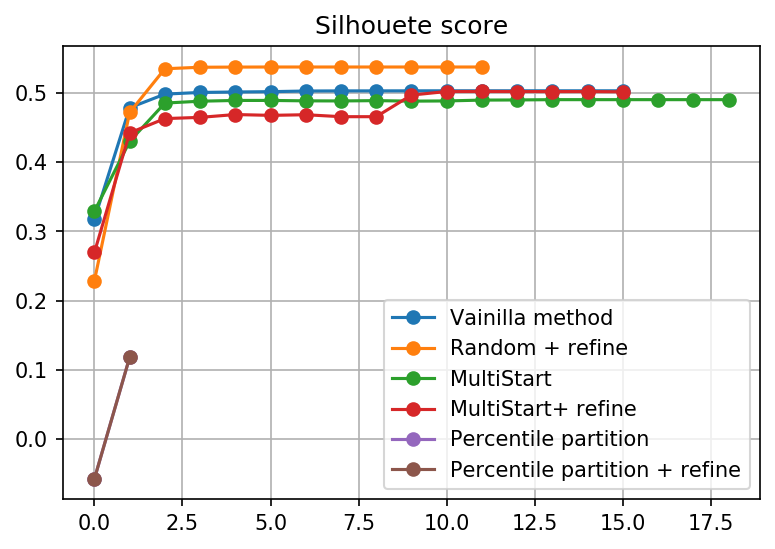

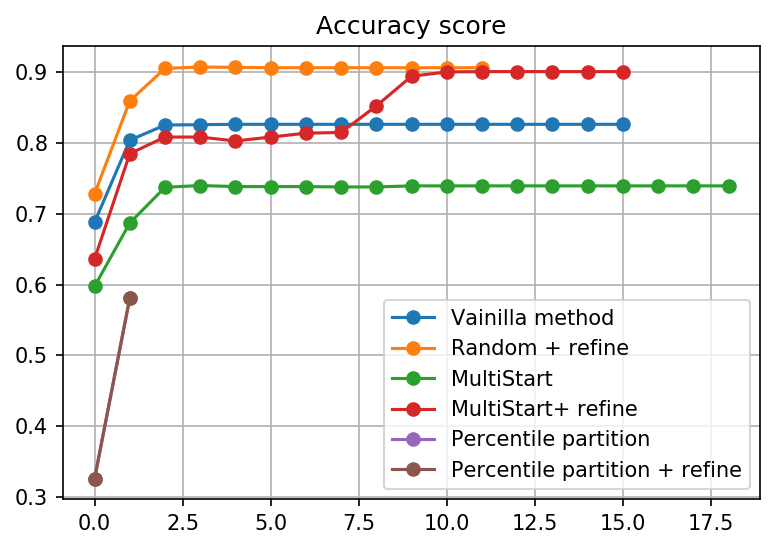

In [0]:

plt.rcParams['figure.dpi']=150

plt.plot(C1.Score, marker='o', label='Vainilla method')
plt.plot(C2.Score,marker='o', label='Random + refine')
plt.plot(C3.Score,marker='o', label='MultiStart')
plt.plot(C4.Score,marker='o', label='MultiStart+ refine')
plt.plot(C5.Score,marker='o', label='Percentile partition')
plt.plot(C6.Score,marker='o', label='Percentile partition + refine')
plt.grid(True)
plt.title("Silhouete score")
plt.legend(loc='best')


plt.show()


plt.plot(C1.Acc, marker='o', label='Vainilla method')
plt.plot(C2.Acc,marker='o', label='Random + refine')
plt.plot(C3.Acc,marker='o', label='MultiStart')
plt.plot(C4.Acc,marker='o', label='MultiStart+ refine')
plt.plot(C5.Acc,marker='o', label='Percentile partition')
plt.plot(C6.Acc,marker='o', label='Percentile partition + refine')
plt.grid(True)
plt.title("Accuracy score")
plt.legend(loc='best')
plt.show()


## **PCA**

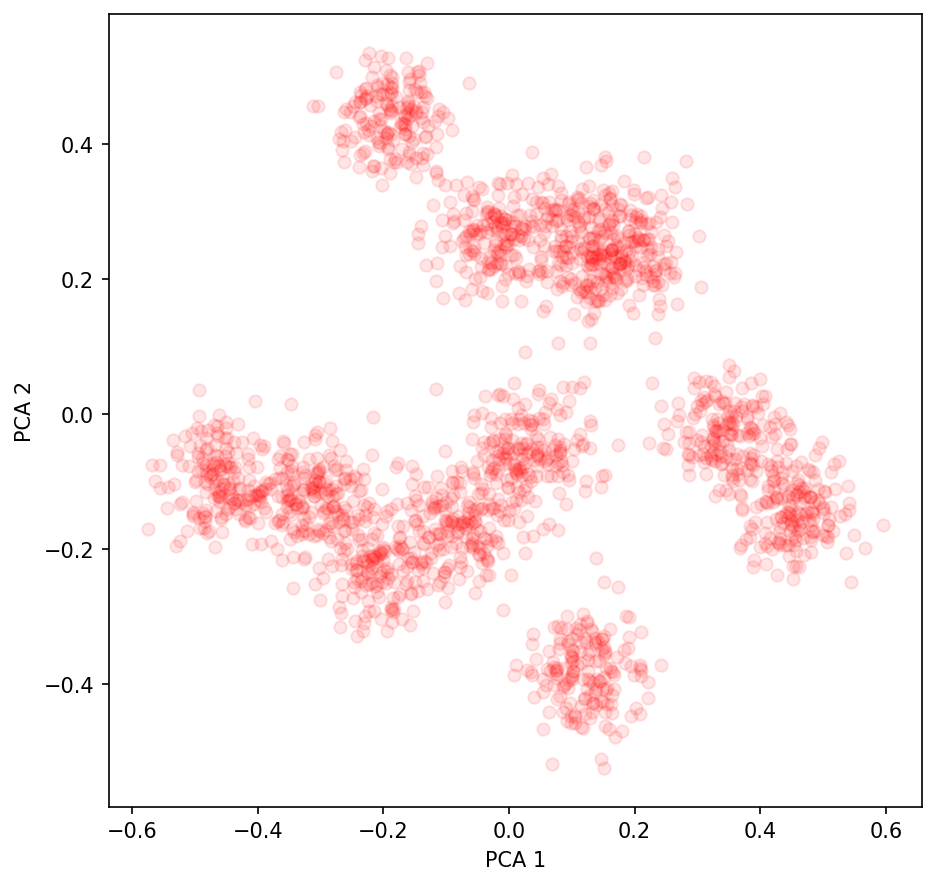

In [0]:
import sklearn.preprocessing
from sklearn.decomposition import PCA

np.random.seed(17)
Dx, Dy = make_blobs(n_samples=2000, n_features=3, centers=12)

scalerDx = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
Xp = scalerDx.fit_transform(Dx)
porcentajeVE = 0.95
sklearn_pca = PCA(porcentajeVE)

pComponents = sklearn_pca.fit_transform(Xp)

plt.figure(figsize = (7,7))
plt.scatter(pComponents[:,0], pComponents[:,1], c= 'r', alpha=.1) 
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

([<matplotlib.axis.XTick at 0x7f89075785f8>,
 <a list of 3 Text xticklabel objects>)

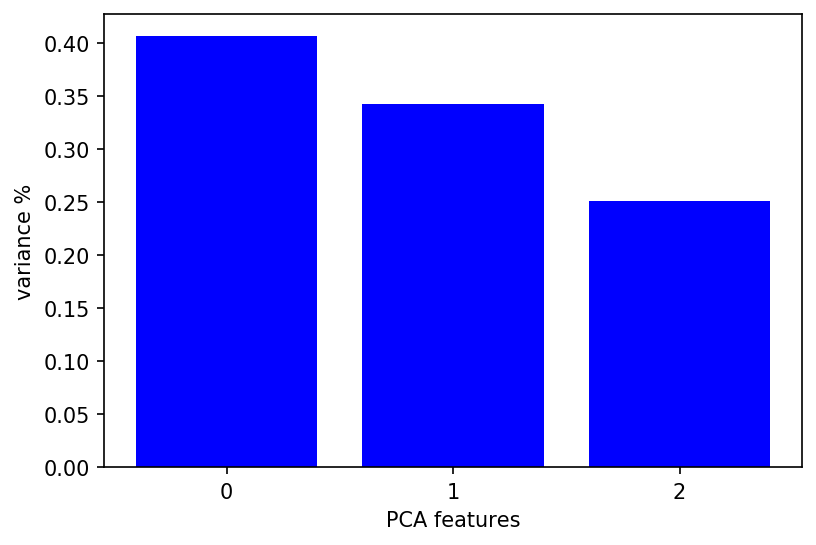

In [0]:
# Plot the explained variances
features = range(sklearn_pca.n_components_)
plt.bar(features, sklearn_pca.explained_variance_ratio_, color='b')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
#pca_comp = pd.DataFrame(pComponents)

In [0]:
print("Dx shape;:::",pComponents.shape)
np.random.seed(5)
R=5
Clust=12

try:
  Method_Name='Random'
  print("\n \n Method:", Method_Name)
  C1=KMeans_VIU(K=Clust,init_type='random')
  C1.fit(pComponents, plot=True, Refine=False, y=Dy)
except:
  print("Did not find convergence on method"+ Method_Name)

try:
  Method_Name='Random + Refine'
  print("\n \n Method:", Method_Name)
  C2=KMeans_VIU(K=Clust,init_type='random')
  C2.fit(pComponents, plot=True, Refine=True, y=Dy,Refine_interval=R)
except:
  print("Did not find convergence on method"+ Method_Name)

try:
  Method_Name='MultiStart'
  print("\n \n Method:", Method_Name)
  C3=KMeans_VIU(K=Clust,init_type='MultiStart')
  C3.fit(pComponents, plot=True, Refine=False, y=Dy)

except:
  print("Did not find convergence on method"+ Method_Name)

try:
  Method_Name='MultiStart + Refine'
  print("\n \n Method:", Method_Name)
  C4=KMeans_VIU(K=Clust,init_type='MultiStart')
  C4.fit(pComponents, plot=True, Refine=True, y=Dy,Refine_interval=R)
except:
  print("Did not find convergence on method"+ Method_Name)

try:
  Method_Name='Percentile partition'
  print("\n \n Method:", Method_Name)
  C5=KMeans_VIU(K=Clust,init_type='Perc_partition')
  C5.fit(pComponents, plot=True, Refine=False, y=Dy)
except:
  print("Did not find convergence on method"+ Method_Name)

try:
  Method_Name='Percentile partition + Refine'
  print("\n \n Method:", Method_Name)
  C6=KMeans_VIU(K=Clust,init_type='Perc_partition')
  C6.fit(pComponents, plot=True, Refine=True, y=Dy,Refine_interval=R)

except:
  print("Did not find convergence on method"+ Method_Name)
















  0%|          | 0/200 [00:00<?, ?it/s]

Dx shape;::: (2000, 3)

 
 Method: Random

 
 Finished centroids initialization 


































  0%|          | 0/200 [00:00<?, ?it/s]

Stopped iterations at  14  iterations
Cannot plot something diferent to 2D
 Silhouette score: 0.5034688668731925
Accuracy: 0.8265

 
 Method: Random + Refine

 
 Finished centroids initialization 


Called refine function

















  2%|▎         | 5/200 [00:18<11:57,  3.68s/it]

Called refine function

















  2%|▎         | 5/200 [00:31<11:57,  3.68s/it]














  5%|▌         | 10/200 [00:37<11:46,  3.72s/it]















  0%|          | 0/100000 [00:00<?, ?it/s]

Stopped iterations at  11  iterations
Cannot plot something diferent to 2D
 Silhouette score: 0.5378440098375794
Accuracy: 0.9065

 
 Method: MultiStart
D max: 68.97501505460151

 Finished centroids initialization 
D max: 78.63706143033137

 Finished centroids initialization 
D max: 80.28369435490795

 Finished centroids initialization 
D max: 81.34412539705232

 Finished centroids initialization 
D max: 83.6725631238452

 Finished centroids initialization 
D max: 84.24648918424833

 Finished centroids initialization 
D max: 86.11677312056254

 Finished centroids initialization 
D max: 86.2812064900961

 Finished centroids initialization 
D max: 87.30024785981206

 Finished centroids initialization 


















  1%|▏         | 1280/100000 [00:02<02:34, 639.80it/s]

D max: 87.51976753233137

 Finished centroids initialization 
D max: 88.36482293673076

 Finished centroids initialization 


















  3%|▎         | 2588/100000 [00:04<02:31, 643.99it/s]















  4%|▍         | 3903/100000 [00:06<02:28, 647.88it/s]















  5%|▌         | 5214/100000 [00:08<02:25, 650.14it/s]















  7%|▋         | 6545/100000 [00:10<02:22, 654.59it/s]

D max: 88.51817900143377

 Finished centroids initialization 


















  8%|▊         | 7861/100000 [00:12<02:20, 655.56it/s]














  5%|▌         | 10/200 [00:51<11:46,  3.72s/it]















  9%|▉         | 9170/100000 [00:14<02:18, 655.10it/s]















 10%|█         | 10480/100000 [00:16<02:16, 654.99it/s]















 12%|█▏        | 11793/100000 [00:18<02:14, 655.36it/s]















 13%|█▎        | 13101/100000 [00:20<02:12, 654.82it/s]

D max: 90.12754640395369

 Finished centroids initialization 
D max: 90.35683767146449

 Finished centroids initialization 


















 14%|█▍        | 14417/100000 [00:22<02:10, 655.74it/s]















 16%|█▌        | 15710/100000 [00:24<02:09, 652.93it/s]















 17%|█▋        | 17032/100000 [00:26<02:06, 655.27it/s]















 18%|█▊        | 18347/100000 [00:28<02:04, 655.80it/s]















 20%|█▉        | 19650/100000 [00:30<02:02, 654.36it/s]

D max: 90.7235201591347

 Finished centroids initialization 


















 21%|██        | 20956/100000 [00:32<02:00, 653.91it/s]















 22%|██▏       | 22267/100000 [00:34<01:58, 654.24it/s]















 24%|██▎       | 23597/100000 [00:36<01:56, 657.40it/s]















 25%|██▍       | 24911/100000 [00:38<01:54, 657.20it/s]















 26%|██▌       | 26234/100000 [00:40<01:52, 658.44it/s]















 28%|██▊       | 27550/100000 [00:42<01:50, 657.58it/s]















 29%|██▉       | 28865/100000 [00:44<01:48, 654.82it/s]















 30%|███       | 30196/100000 [00:46<01:46, 657.85it/s]















 32%|███▏      | 31525/100000 [00:48<01:43, 659.75it/s]















 33%|███▎      | 32848/100000 [00:50<01:41, 660.13it/s]

D max: 91.88160401851428

 Finished centroids initialization 


















 34%|███▍      | 34169/100000 [00:52<01:40, 657.86it/s]















 35%|███▌      | 35492/100000 [00:54<01:37, 658.88it/s]















 37%|███▋      | 36810/100000 [00:56<01:36, 653.66it/s]















 38%|███▊      | 38141/100000 [00:58<01:34, 657.05it/s]















 39%|███▉      | 39456/100000 [01:00<01:32, 655.86it/s]















 41%|████      | 40768/100000 [01:02<01:30, 654.91it/s]















 42%|████▏     | 42078/100000 [01:04<01:28, 653.67it/s]















 43%|████▎     | 43395/100000 [01:06<01:26, 654.99it/s]















 45%|████▍     | 44716/100000 [01:08<01:24, 656.51it/s]















 46%|████▌     | 46030/100000 [01:10<01:22, 655.71it/s]















 47%|████▋     | 47342/100000 [01:12<01:20, 655.72it/s]















 49%|████▊     | 48655/100000 [01:14<01:18, 655.93it/s]















 50%|████▉     | 49967/100000 [01:16<01:16, 650.00it/s]















 51%|█████▏    | 51295/100000 [01:18<01:14, 654.01it/s]







[[-0.23166418  0.38632959 -0.18479179]
 [-0.3045214   0.45708001 -0.11019003]
 [ 0.05832846 -0.40079294 -0.10782342]
 [-0.23552869 -0.26408934  0.14080205]
 [-0.16012119  0.46327085 -0.21535544]
 [ 0.05366875 -0.41169483 -0.03635719]
 [ 0.51828662 -0.11066058 -0.33509299]
 [-0.57492773 -0.17009272 -0.0713982 ]
 [ 0.36518837 -0.03148662 -0.01360368]
 [ 0.10466905 -0.45709023 -0.12064283]
 [ 0.26431748  0.33654768  0.39554281]
 [ 0.16067138  0.31909251  0.36496636]]



















  0%|          | 0/100000 [00:00<?, ?it/s]

Stopped iterations at  11  iterations
Cannot plot something diferent to 2D
 Silhouette score: 0.48977371815810405
Accuracy: 0.7435

 
 Method: MultiStart + Refine
D max: 81.8528289893916

 Finished centroids initialization 
D max: 82.1996761720514

 Finished centroids initialization 
D max: 82.90445311774623

 Finished centroids initialization 
D max: 83.69556723363007

 Finished centroids initialization 
D max: 88.95533078474627

 Finished centroids initialization 
D max: 89.10787296787099

 Finished centroids initialization 



















  1%|▏         | 1294/100000 [00:02<02:32, 646.79it/s]
















  3%|▎         | 2622/100000 [00:04<02:29, 651.75it/s]
















  4%|▍         | 3942/100000 [00:06<02:26, 654.16it/s]
















  5%|▌         | 5244/100000 [00:08<02:25, 653.17it/s]
















  7%|▋         | 6572/100000 [00:10<02:22, 656.24it/s]
















  8%|▊         | 7902/100000 [00:12<02:19, 658.73it/s]
















  9%|▉         | 9223/100000 [00:14<02:17, 659.16it/s]
















 11%|█         | 10551/100000 [00:16<02:15, 660.53it/s]
















 12%|█▏        | 11870/100000 [00:18<02:13, 660.19it/s]
















 13%|█▎        | 13159/100000 [00:20<02:12, 655.32it/s]
















 14%|█▍        | 14471/100000 [00:22<02:10, 655.45it/s]
















 16%|█▌        | 15786/100000 [00:24<02:08, 655.97it/s]
















 17%|█▋        | 17083/100000 [00:26<02:06, 653.67it/s]
















 18%|█▊        | 18406/100000 [00:28<02:04, 655.92it/s

D max: 89.51631847566009

 Finished centroids initialization 



















 20%|█▉        | 19710/100000 [00:30<02:05, 640.26it/s]
















 21%|██        | 20988/100000 [00:32<02:03, 639.81it/s]
















 22%|██▏       | 22265/100000 [00:34<02:01, 637.66it/s]
















 24%|██▎       | 23541/100000 [00:36<01:59, 637.54it/s]
















 25%|██▍       | 24839/100000 [00:38<01:57, 640.92it/s]
















 26%|██▌       | 26146/100000 [00:40<01:54, 644.59it/s]
















 27%|██▋       | 27472/100000 [00:42<01:51, 649.91it/s]
















 29%|██▉       | 28815/100000 [00:44<01:48, 656.12it/s]
















 30%|███       | 30135/100000 [00:46<01:46, 657.22it/s]
















 31%|███▏      | 31461/100000 [00:48<01:44, 658.90it/s]

D max: 91.86154058773512

 Finished centroids initialization 



















 33%|███▎      | 32779/100000 [00:50<01:43, 651.72it/s]
















 34%|███▍      | 34120/100000 [00:52<01:40, 657.14it/s]
















 35%|███▌      | 35435/100000 [00:54<01:38, 656.42it/s]
















 37%|███▋      | 36764/100000 [00:56<01:36, 658.68it/s]
















 38%|███▊      | 38082/100000 [00:58<01:34, 654.11it/s]
















 39%|███▉      | 39391/100000 [01:00<01:33, 651.26it/s]
















 41%|████      | 40705/100000 [01:02<01:30, 652.89it/s]
















 42%|████▏     | 42012/100000 [01:04<01:28, 652.77it/s]
















 43%|████▎     | 43318/100000 [01:06<01:26, 652.52it/s]
















 45%|████▍     | 44629/100000 [01:08<01:24, 653.30it/s]
















 46%|████▌     | 45936/100000 [01:10<01:23, 647.61it/s]
















 47%|████▋     | 47269/100000 [01:12<01:20, 653.04it/s]
















 49%|████▊     | 48576/100000 [01:14<01:19, 650.36it/s]
















 50%|████▉     | 49895/100000 [01:16<01:16, 652

[[ 0.56655822 -0.19883436 -0.29162563]
 [-0.45082044 -0.07681482 -0.0760103 ]
 [-0.21762903 -0.0599742  -0.17742104]
 [-0.17028878 -0.20045823  0.15644264]
 [-0.18557035  0.48344257 -0.17946692]
 [-0.52067722 -0.07546831 -0.1025529 ]
 [-0.22966132  0.48143676 -0.20035991]
 [ 0.49225454 -0.12762997 -0.40484289]
 [ 0.14064491  0.16917957  0.36961813]
 [ 0.22001239  0.28212465  0.44422547]
 [ 0.098045   -0.38878013 -0.0482028 ]
 [-0.19605304  0.51032894 -0.21377532]]
Called refine function
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!



















  2%|▎         | 5/200 [00:17<11:36,  3.57s/it]

Called refine function



















  5%|▌         | 10/200 [00:35<11:19,  3.58s/it]

Called refine function
!!!!!!!!!Switched between clusters !!!!!!!!!!



















  5%|▌         | 10/200 [00:46<11:19,  3.58s/it]
















  8%|▊         | 15/200 [00:53<11:02,  3.58s/it]

















  0%|          | 0/200 [00:00<?, ?it/s]

Stopped iterations at  15  iterations
Cannot plot something diferent to 2D
 Silhouette score: 0.5020201986510894
Accuracy: 0.901

 
 Method: Percentile partition

 
 Finished centroids initialization 


[[-0.15041864 -0.14046799 -0.1191235 ]
 [-0.1646572  -0.15336673 -0.13009558]
 [-0.17777586 -0.16525094 -0.14020467]
 [-0.16308931 -0.15194638 -0.12888738]
 [-0.14387678 -0.13454172 -0.11408241]
 [-0.12013558 -0.11303452 -0.0957877 ]
 [-0.03320202 -0.03428127 -0.02879767]
 [ 0.09979595  0.0862018   0.0736891 ]
 [ 0.1632907   0.1437218   0.12261745]
 [ 0.2182956   0.19355082  0.16500361]
 [ 0.23249013  0.20640967  0.17594176]
 [ 0.25690091  0.22852344  0.19475245]]





















  0%|          | 0/200 [00:00<?, ?it/s]

Stopped iterations at  20  iterations
Cannot plot something diferent to 2D
 Silhouette score: 0.5231802900333739
Accuracy: 0.899

 
 Method: Percentile partition + Refine

 
 Finished centroids initialization 


[[-0.15041864 -0.14046799 -0.1191235 ]
 [-0.1646572  -0.15336673 -0.13009558]
 [-0.17777586 -0.16525094 -0.14020467]
 [-0.16308931 -0.15194638 -0.12888738]
 [-0.14387678 -0.13454172 -0.11408241]
 [-0.12013558 -0.11303452 -0.0957877 ]
 [-0.03320202 -0.03428127 -0.02879767]
 [ 0.09979595  0.0862018   0.0736891 ]
 [ 0.1632907   0.1437218   0.12261745]
 [ 0.2182956   0.19355082  0.16500361]
 [ 0.23249013  0.20640967  0.17594176]
 [ 0.25690091  0.22852344  0.19475245]]
Called refine function



















  8%|▊         | 15/200 [01:07<11:02,  3.58s/it]

!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!





















  2%|▎         | 5/200 [00:18<11:43,  3.61s/it]

Called refine function





















  2%|▎         | 5/200 [00:29<11:43,  3.61s/it]

!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!





















  5%|▌         | 10/200 [00:37<11:37,  3.67s/it]

Called refine function





















  5%|▌         | 10/200 [00:49<11:37,  3.67s/it]

!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!





















  8%|▊         | 15/200 [00:56<11:29,  3.73s/it]

Called refine function





















  8%|▊         | 15/200 [01:09<11:29,  3.73s/it]

!!!!!!!!!Switched between clusters !!!!!!!!!!
!!!!!!!!!Switched between clusters !!!!!!!!!!





















 10%|█         | 20/200 [01:15<11:17,  3.77s/it]

Stopped iterations at  20  iterations
Cannot plot something diferent to 2D
 Silhouette score: 0.5231802900333739
Accuracy: 0.899


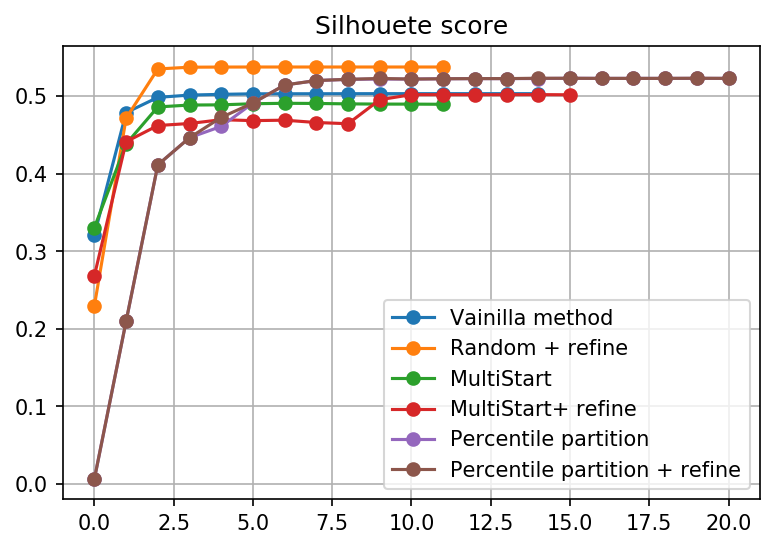

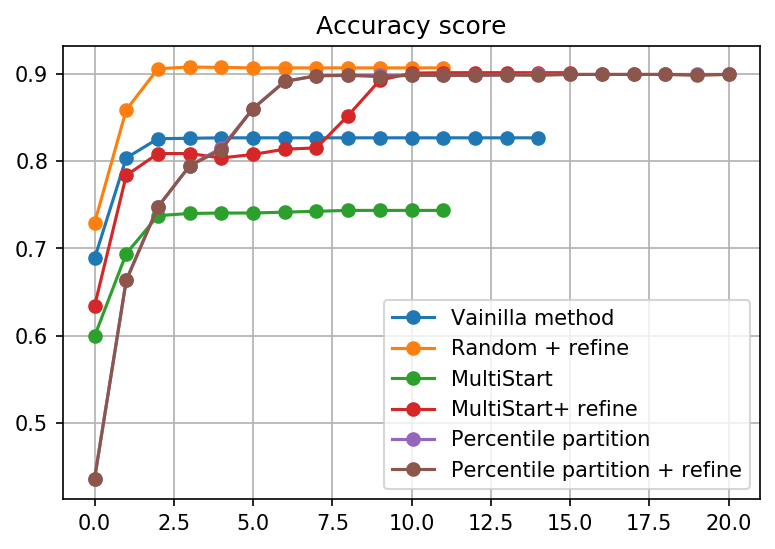

In [0]:

plt.rcParams['figure.dpi']=150

plt.plot(C1.Score, marker='o', label='Vainilla method')
plt.plot(C2.Score,marker='o', label='Random + refine')
plt.plot(C3.Score,marker='o', label='MultiStart')
plt.plot(C4.Score,marker='o', label='MultiStart+ refine')
plt.plot(C5.Score,marker='o', label='Percentile partition')
plt.plot(C6.Score,marker='o', label='Percentile partition + refine')
plt.grid(True)
plt.title("Silhouete score")
plt.legend(loc='best')


plt.show()


plt.plot(C1.Acc, marker='o', label='Vainilla method')
plt.plot(C2.Acc,marker='o', label='Random + refine')
plt.plot(C3.Acc,marker='o', label='MultiStart')
plt.plot(C4.Acc,marker='o', label='MultiStart+ refine')
plt.plot(C5.Acc,marker='o', label='Percentile partition')
plt.plot(C6.Acc,marker='o', label='Percentile partition + refine')
plt.grid(True)
plt.title("Accuracy score")
plt.legend(loc='best')
plt.show()


# Resultados
 Los resultados  respecto al dataset 1 y 2  son dificiles de contrastar ya que estos datasets pueden ser considerados "toy datasets" en ocasiones por su simplicidad y limpieza relativa o la poca cantidad de centros.  <br>
## Dataset 1
Se puede destacar el método MultiStart + Refine  destacó sobre todos los  demas tanto el  las medidas intrinsecas como en las medidas intrinsecas  ademas que visualmente fue el unico que logró separar correctamente el  los dos clusters del lado izquierdo, dado que los demas métodos tienden a separar el Cluster inferior izquierdo (original azul)  en dos clusters diferentes el algoritmo de Multi Start+ Refine   lo mantuvo como uno solo  valiendo de una mejora un el score de silueta y  de accuracy.

## Dataset 2
En el dataset el resultado final en medidas intrinsecas y extrinsecas es practicamente el mismo para todos los métodos siendo la hipotesis principal  la simplicidad y pureza  del dataset  sin embargo se puede observar que los métodos con el refine alcanzan métricas más altas más tempranamente que métodos que no la usan.

## Dataset 3
En el caso del  dataset 3 se decidio generar un juego de datos con una cantidad de centros  grande (12) para contrastar los métodos respecto  a un especio de búsqueda más grande. En este caso se puede observar que el método vainilla fue superado  por el método  Vainilla+ refine y el método  MultiStart + refine.

# Sección nueva

# Referencias

*   A Comparative Study of Efficient Initialization Methods for the K-Means
Clustering Algorithm [2012]. Recuperado de https://arxiv.org/pdf/1209.1960.pdf

*   K-means Clustering via Principal Component Analysis. Chris Ding and Xiaofeng He. Recuperado de http://ranger.uta.edu/~chqding/papers/KmeansPCA1.pdf

*   A Deterministic Method for Initializing K-means Clustering. Recuperado de https://ece.northeastern.edu/fac-ece/jdy/papers/init-kmeans.pdf

